In [1]:
import random
import requests
import json
import edist.tree_utils as tree_utils
import edist.ted as ted
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
import edist.sed as sed
import edist.aed as aed
import edist.dtw as dtw
import edist.seted as seted
import edist.tree_edits as tree_edits

In [2]:
def random_generator(internal,leaves,min_nodes, max_nodes, min_depth, max_depth):
    

    nodes = ['r','s']
    adj=[[1],[]]
    internal_nodes=[1]
    leaf_nodes=[]

    depth=random.randint(min_depth,max_depth)
    for d in range(depth):
        # If we are at the deepest level, we only choose from leaf nodes
        last=(d+1==depth)
        if last:
            valid_nodes=leaves 
        else:
            valid_nodes=internal+leaves

        # For each internal node, we append new children
        for inter in internal_nodes:
            num_new_nodes=random.randint(min_nodes,max_nodes)
            for n in range(num_new_nodes):
                new_node=random.choice(valid_nodes)
                nodes.append(new_node)
                adj.append([])
                adj[inter].append(len(nodes)-1)
                if new_node in internal:
                    internal_nodes.append(len(nodes)-1)
                else:                    
                    leaf_nodes.append(len(nodes)-1)  
                    
                    if new_node not in leaves:
                        leaves.remove(new_node) # So explainers do not appear more than once
                        valid_nodes=internal+leaves
                    
            internal_nodes.remove(inter)
            
        # If we are not at the deepest level and we don't have internal nodes, we randomly pick one of the leaf nodes
        # of that level and replace it with an internal node
        if (not(last or internal_nodes)):  
            replace_index=random.choice(leaf_nodes)
            nodes[replace_index]=random.choice(internal)
            internal_nodes.append(replace_index)
        leaf_nodes.clear()
    
    return dict(nodes=nodes, adj=adj)

In [3]:
def print_tree(tree):
    print(tree_utils.tree_to_string(tree["nodes"], tree["adj"]))

In [4]:
def knn(q,cases,similarity_func,k=3,delta=None):
    
    cases_cpy=cases.copy()
    similarities=[]
    for case in cases_cpy:
        sim = similarity_func(q,case,delta)
        similarities.append(similarity_func(q,case,delta))
    nns=[]
    for i in range(k):
        if cases_cpy:
            index=similarities.index(min(similarities))
            nns.append(cases_cpy[index])
            similarities.pop(index)
            cases_cpy.pop(index)
        else:
            break
        
        
    return nns   

In [5]:
def loadNodes():
    internal=['s','p']
    #leaves=['f','t']
    leaves=[]
    
    response=requests.get("https://explainers-dev.isee4xai.com/Explainers")
    if response.ok:
        leaves=leaves+json.loads(response.text)
    else:
        raise Exception("Could not load available explainers.")
        
    #HACK
    leaves.remove('/Images/IntegratedGradients')
    
    return internal,leaves

In [6]:
def loadNodesStatic(df):
    internal=['s','p']
    #leaves=['f','t']
    leaves=[]
    leaves=leaves+list(df.columns)
    return internal,leaves

In [7]:
def generateCaseBase(min_nodes, max_nodes, min_depth, max_depth,n=100):
    
    #internal,leaves = loadNodes()
    internal,leaves = loadNodesStatic(leaves_dataframe)

    casebase=[]
    for i in range(n):
        casebase.append(random_generator(internal,leaves,min_nodes, max_nodes, min_depth, max_depth))
        
    return casebase

In [8]:
def serializeCaseBase(casebase, file):
    
     with open(file,'w') as f:
        json.dump(casebase,f)    

In [9]:
def deserializeCaseBase(file):
    
    with open(file) as f:
        casebase=json.load(f) 
        
    return casebase

In [10]:
def editDistFunc(q,c,delta):
    s1=[]
    explainer_sequence(q,q["nodes"][0],q["adj"][0],s1)
    s2=[]
    explainer_sequence(c,c["nodes"][0],c["adj"][0],s2)
    dist = sed.sed(s1,s2,delta)
    return dist

In [11]:
#Finds the knn's for each case and calculates the edit distance with each
def getKnnEditDistances(casebase,similarity_func,k=3,delta=None):
    
    print(delta)
    
    avg_editDistances=[]
    min_editDistances=[]
    max_editDistances=[]
    cont = 0
    for q in casebase:
        cont = cont + 1
        casebase_cpy=casebase.copy()
        casebase_cpy.remove(q)
        nns=knn(q,casebase_cpy,similarity_func,k,delta)
        distances = [editDistFunc(q,nn,delta) for nn in nns]
        # print(distances)
        avg_editDistances.append(sum(distances)/len(nns))
        min_editDistances.append(min(distances))
        maxvalue = max(distances)
        if maxvalue == np.inf:
            maxvalue = 10
        max_editDistances.append(maxvalue)        
    
    return avg_editDistances, min_editDistances, max_editDistances 

## Similarity Metrics

In [12]:
# delta: custom node distance function
def semantic_delta(x, y):
    df = getSimilarityTable()
    #print(df["/Images/Anchors"]["/Images/Counterfactuals"])

    if(x==y):
        ret = 0.
    elif(x!=None and y==None): #inserting
        #print("inserting")
        ret = insertion_cost
    elif(x==None and y!=None): #deleting
        #print("deleting")
        ret = deletion_cost
    elif(x=='r'or y=='r'):  #we assign an infinite cost when comparing a root node
        #print("root")
        ret = np.inf
    elif(x in ['f','t'] and y in ['f','t']): #if both nodes are either failer or succeeder, assign null cost
        #print("failer and succeeder")
        ret = 0.
    elif(x in ['s','p'] and y in['s','p']): #if both nodes are either sequence or priority, assign null cost
        #print("sequence and priority")
        ret = 0.
    elif(x in ['s','p'] or y in ['s','p']): #if one of the nodes is a sequence or priority, the other won't because of the previous rule
        #print("sequence or priority")
        ret = np.inf
    elif(x in ['f','t'] and y[0]=='/'):
        #print("cambiando explainer por failure or succeeder")
        ret = leave_change
    elif(x[0]=='/' and y in ['f','t']):
        #print("cambiando explainer por failure or succeeder")
        ret = leave_change
    elif x in df.columns and y in df.columns: #Both explainers are in similarity table, DF MUST BE LOADED BEFOREHAND
        #print("changing explainers")
#         if(df.loc[x][y]>.5):
#             ret = 0
#         else:
#             ret = leave_change
        ret = 1-df.loc[x][y]
    else :
        ret = 10 #default_cost
        print("SEMANTIC delta ++++++++++++++++++++++++++")
        print(x)
        print(y)
        #print('sem_delta_unknown: ',str(x)," , "+str(y)+ " = "+ str(ret) )   
       
    #print('sem_delta: ',str(x)," , "+str(y)+ " = "+ str(ret) )   
    return ret



In [13]:
# delta: custom node distance function
def std_delta(x, y):    
    if(x==y):
        ret = 0.
    elif(x!=None and y==None): #inserting
        ret = insertion_cost
    elif(x==None and y!=None): #deleting
        ret = deletion_cost
    elif(x=='r'or y=='r'):  #we assign an infinite cost when comparing a root node
        ret = np.inf
    elif(x in ['f','t'] and y in ['f','t']): #if both nodes are either failer or succeeder, assign null cost
        ret = 0.
    elif(x in ['s','p'] and y in['s','p']): #if both nodes are either sequence or priority, assign null cost
        ret = 0.
    elif(x in ['s','p'] or y in ['s','p']): #if one of the nodes is a sequence or priority, the other won't because of the previous rule
        ret = np.inf
    elif(x in ['f','t'] and y[0]=='/'):
        ret = leave_change
    elif(x[0]=='/' and y in ['f','t']):
        ret = leave_change
    elif(x[0] == '/' and y[0]=='/'):
        ret =  leave_change
    else :
        ret = 10 #default_cost
        print("NO SEMANTIC delta ++++++++++++++++++++++++++")
        print(x)
        print(y)
        #print('delta_unknown: ',str(x)," , "+str(y)+ " = "+ str(ret) )   

    #print('delta: ',str(x)," , "+str(y)+ " = "+ str(ret) )   
    return ret

In [14]:
insertion_cost = 1.
deletion_cost = 1.
leave_change = 1.
default_cost = 100

# distance_factor=3
# distance_factor=3

global leaves_dataframe

def getSimilarityTable():
    return leaves_dataframe

In [15]:
# The overlap coefficient, or Szymkiewicz–Simpson coefficient
def overlap_similarity(q,c,delta:None): #Shared explainers
    
    mq= [node for node in q["nodes"] if node[0]=='/']
    mc= [node for node in c["nodes"] if node[0]=='/']
    
    if min(len(mq),len(mc)) == 0:
        return 0
    else:
        return len(set(mq)&set(mc))/min(len(mq),len(mc)) #* distance_factor

In [16]:
#same as similarity, but considers all the nodes (except root), not only the explainers 
#NOT USED
def joint_nodes(q,c):
    
    mq= [node for node in q["nodes"] if node!='r']
    mc= [node for node in c["nodes"] if node!='r']
    
    return len(set(mq)&set(mc))/len(mq)

In [17]:
# Returns a list of explainers in the same order specified by the tree
def explainer_sequence(tree,node,adj_node,seq):
    seq.append(node)
    if adj_node: 
        for child in adj_node:
            explainer_sequence(tree, tree["nodes"][child],tree["adj"][child],seq)

In [18]:
def explainer_sequence_SequenceMatch(tree,node,adj_node,seq):
    if not adj_node: #leaf
        if node not in ["f","t","r"]: #explainer
            seq.append(node)
        return
    for child in adj_node:
        explainer_sequence_SequenceMatch(tree, tree["nodes"][child],tree["adj"][child],seq)

In [19]:
# #internal,leaves = loadNodes()
#internal,leaves = loadNodesStatic(getSimilarityTable())

# tree=random_generator(internal,leaves,3,5,3,4)
# print(tree_utils.tree_to_string(tree["nodes"], tree["adj"]))
# sq=[]
# #explainer_sequence(tree,tree["nodes"][0], tree["adj"][0],sq)
# #print(sq)

In [20]:
# sq=[]
# explainer_sequence_SequenceMatch(tree,tree["nodes"][0], tree["adj"][0],sq)
# print(sq)

In [21]:
#def explainer_sequence(tree,node,adj_node,seq):
#    if not adj_node: #leaf
#        if node not in ["f","t","r"]: #explainer
#            seq.append(node)
#        return
    
#    for child in adj_node:
#        explainer_sequence(tree, tree["nodes"][child],tree["adj"][child],seq)

In [22]:
# similarity metric that considers the order of explainer nodes
#NOT USED
def ordering_leaves(q,c):
    
    sq=[]
    explainer_sequence(q,q["nodes"][0],q["adj"][0],sq)
    sc=[]
    explainer_sequence(c,c["nodes"][0],c["adj"][0],sc)
    
    min_size=min(len(sq),len(sc))
    equals=0
    for i in range(min_size):
        if sq[i]==sc[i]:
            equals=equals+1
        
    return equals/min_size

In [23]:
# simple sequence match from the begining of both sequences
def sequence_match_similarity(q,c,delta=None):
    
    sq=[]
    explainer_sequence_SequenceMatch(q,q["nodes"][0],q["adj"][0],sq)
    sc=[]
    explainer_sequence_SequenceMatch(c,c["nodes"][0],c["adj"][0],sc)
    
    min_size=min(len(sq),len(sc))
    maxdist = max(len(sq),len(sc))
    sim=0
    
    for i in range(min_size):
        x = sq[i]
        y = sc[i]
        if delta == None:
            if sq[i]==sc[i]:
                sim += 1
        else:
            sim += delta(x,y)

    # print("sequence_match: "+ str(sim/min_size))
    #return distance_factor*(sim/maxdist)

    return  sim/(maxdist*insertion_cost)



In [24]:
# Referencias aquí: https://gitlab.ub.uni-bielefeld.de/bpaassen/python-edit-distances

# sequence edit distance of Levenshtein (1965)
def levenshtein_similarity(q,c, delta=None):
    s1=[]
    explainer_sequence(q,q["nodes"][0],q["adj"][0],s1)
    s2=[]
    explainer_sequence(c,c["nodes"][0],c["adj"][0],s2)

    dist = sed.sed(s1,s2, delta)
    # maxdist = max(len(s1),len(s2))
    # return  (1-(dist/(maxdist*insertion_cost)))
    return dist
    
# sequence edit distance with affine gap costs using algebraic dynamic programming (ADP; Giegerich, Meyer, and Steffen, 2004),
# as applied by Paaßen, Mokbel, and Hammer (2016)
def aed_similarity(q,c, delta=None):
    s1=[]
    explainer_sequence(q,q["nodes"][0],q["adj"][0],s1)
    s2=[]
    explainer_sequence(c,c["nodes"][0],c["adj"][0],s2)
    dist = aed.aed(s1,s2,delta)
    #maxdist = max(len(s1),len(s2))
    
    #return distance_factor*(1-(dist/maxdist))
    #return  (1-(dist/(maxdist*insertion_cost)))
    return dist
    
def default_dtw_distance(x,y):
    if x==y:
        return 0
    else: 
        return insertion_cost

# dynamic time warping distance of Vintsyuk (1968)    
def dtw_similarity(q,c, delta=None):
    s1=[]
    explainer_sequence(q,q["nodes"][0],q["adj"][0],s1)
    s2=[]
    explainer_sequence(c,c["nodes"][0],c["adj"][0],s2)
    if delta==None:
        delta = default_dtw_distance
    dist = dtw.dtw(s1,s2,delta)
    #maxdist = max(len(s1),len(s2))
    
    #return distance_factor*(1-(dist/maxdist))
    #return  (1-(dist/(maxdist*insertion_cost)))
    return dist
    
# Hungarian algorithm of Kuhn, 1955 
def set_similarity(q,c, delta=None):
    s1=[]
    explainer_sequence(q,q["nodes"][0],q["adj"][0],s1)
    s2=[]
    explainer_sequence(c,c["nodes"][0],c["adj"][0],s2)
    dist = seted.seted(s1,s2,delta)
    #maxdist = max(len(s1),len(s2))
    
    #return  (1-(dist/(maxdist*insertion_cost)))
    return dist

# TED similarity
def ted_similarity(q,c,delta=None):
    s1=[]
    explainer_sequence(q,q["nodes"][0],q["adj"][0],s1)
    s2=[]
    explainer_sequence(c,c["nodes"][0],c["adj"][0],s2)

    dist = ted.ted(q["nodes"], q["adj"], c["nodes"], c["adj"],delta)
    #maxdist = max(len(s1),len(s2))
    #return  (1-(dist/(maxdist*insertion_cost)))
    return dist

### Testing

In [25]:
#internal,leaves = loadNodes()
# tree=random_generator(internal,leaves,3,5,3,4)
# print(tree_utils.tree_to_string(tree["nodes"], tree["adj"]))

In [26]:
# leaves_dataframe=pd.read_csv('detail.csv',index_col=0)

In [27]:
# casebase=generateCaseBase(min_nodes = 2, max_nodes = 4, min_depth=2, max_depth=5, n=50)

In [28]:
# serializeCaseBase(casebase,"casebase.json")

In [29]:
#serializeCaseBase(casebase,"casebase-without-f-t.json")

In [30]:
casebase=deserializeCaseBase("casebase-without-f-t-300.json")

In [31]:
#casebase=deserializeCaseBase("casebase-25-test.json")

In [32]:
def seeBugConditionNoedsHasChildren(name_casebase):
    casebaseToTest=deserializeCaseBase(name_casebase)
    nodesWrong = list()
    for elem in casebaseToTest:
        cont_nodes = 0
        for node in elem["nodes"]:
            cont_nodes = cont_nodes + 1
            if node == 's' or node == 'p':
                if elem["adj"][cont_nodes-1] == []:
                    nodesWrong.append(cont_nodes)
    return nodesWrong

In [33]:
print(seeBugConditionNoedsHasChildren("casebase-without-f-t-300.json")) # if the list is empty, the case base is fine

[]


In [34]:
# delta=semantic_delta
# leaves_dataframe=pd.read_csv('detail.csv',index_col=0)
# set_similarity(casebase[0],casebase[1],delta)

In [35]:
# _avg,_min,_max=getKnnEditDistances(casebase,dtw_similarity,3,delta)

In [36]:
# for c in casebase:
#     sc = []
#     explainer_sequence(c,c["nodes"][0],c["adj"][0],sc)
#     print(sc)

In [37]:
import matplotlib.pyplot as plt

def plotEditDistances(editDistances,sim_func_name,dist_func_name):
    plt.figure()
    plt.title("Edit Distances for \nKNN:" + sim_func_name+ "\nDelta: " + dist_func_name)
    plt.plot(range(1,len(editDistances)+1),editDistances)
    plt.show()
    #print("Mean: " + str(np.mean(editDistances)))
    #print("STD: " + str(np.std(editDistances)))

In [38]:
def plotEditDistancesHistogram(_avg,_min,_max,sim_func_name,dist_func_name, k):
    plt.figure(figsize=(6,3), tight_layout=True)

    plt.title("Edit Distances\n" + sim_func_name+ "  Delta: " + dist_func_name+"  k: "+str(k))
    plt.hist(_min)
    plt.hist(_avg, alpha = .5)
    plt.hist(_max, alpha = .2)
    plt.legend(loc='upper right', title_fontsize = 13, labels=['min', 'avg', 'max'])
    plt.xticks(np.arange(0,15*insertion_cost,insertion_cost)) 
    plt.show()
    #print("[MIN] Mean: " + str(np.mean(_min))+"   STD: " + str(np.std(_min)))
    #print("[AVG] Mean: " + str(np.mean(_avg))+"   STD: " + str(np.std(_avg)))
    #print("[MAX] Mean: " + str(np.mean(_max))+"   STD: " + str(np.std(_max)))


In [39]:
# sf = dtw_similarity
# #_avg,_min,_max=getKnnEditDistances(casebase,dtw_similarity,3,delta)
# plotEditDistances(_avg,sf.__name__,"delta")


# plotEditDistancesHistogram(_avg,_min,_max,sf.__name__,"delta", k=3)



## testing Additional metrics

In [40]:
# print(tree_utils.tree_to_string(casebase[5]["nodes"], casebase[5]["adj"]))
# print(tree_utils.tree_to_string(casebase[6]["nodes"], casebase[6]["adj"]))

In [41]:
def DTWDistance(s, t): 
    DTW =list()
    
    for i in range(len(s)-1):
        DTW.append(list())
        for j in range(len(t)-1):
            DTW[i].append(np.inf)
    DTW[0][0] = 0
    
    for i in range(1,len(s)-1): 
        for j in range(1,len(t)-1):
            cost = semantic_delta(s[i], t[j])
            print("********************************************")
            print("Vuelta: " + str(i) + " " + str(j))
            print("s: " + s[i])
            print("t: " + t[j])
            print("Coste: " + str(cost))
            print("DTW[i-1][j]: " + str(DTW[i-1][j]))
            print("DTW[i][j-1]: " + str(DTW[i][j-1]))
            print("DTW[i-1][j-1]: " + str(DTW[i-1][j-1]))
            DTW[i][j] = cost + min(DTW[i-1][j], DTW[i][j-1], DTW[i-1][j-1]) 
            print("str(DTW[i][j]: " + str(DTW[i][j]))
    
    return DTW


In [42]:
s = ['r', 's', '/Tabular/DeepSHAPGlobal', 'p', 's', '/Text/LIME', '/Tabular/Anchors', '/Tabular/NICE', '/Images/Anchors', '/Misc/AIModelPerformance', '/Tabular/DisCERN', 'p', '/Tabular/KernelSHAPLocal', '/Tabular/DeepSHAPLocal', '/Tabular/DicePublic']
t = ['r', 's', '/Tabular/DeepSHAPGlobal', 'p', '/Tabular/TreeSHAPLocal', 's', '/Text/LIME', '/Tabular/Anchors', '/Tabular/NICE', '/Images/Anchors', '/Misc/AIModelPerformance', '/Tabular/DisCERN', 'p', '/Tabular/KernelSHAPLocal', '/Tabular/DeepSHAPLocal', '/Tabular/DicePublic']

In [43]:
#print(DTWDistance(s, t))

In [44]:
len(casebase)

300

### Experiment



In [45]:
# similarity_functions=[overlap_similarity,sequence_match_similarity,levenshtein_similarity,ted_similarity,dtw_similarity,set_similarity]
similarity_functions=[aed_similarity,ted_similarity,dtw_similarity,set_similarity]


#distance_tables=["None","wsim/ca.csv", "wsim/cosine.csv", "wsim/depth.csv","wsim/detail.csv"] #"common_attributes.csv"
#distance_tables=["None","unweighted/ca.csv", "unweighted/cosine.csv", "unweighted/depth.csv","unweighted/detail.csv",
#                        "weighted/ca.csv", "weighted/cosine.csv", "weighted/depth.csv","weighted/detail.csv"]
distance_tables=["None","unweighted/ca.csv", "unweighted/cosine.csv", "unweighted/depth.csv","unweighted/detail.csv"]

k_values = [1,3,5,10,20]
#k_values = [3]

In [46]:
#casebase=generateCaseBase(min_nodes = 2, max_nodes = 4, min_depth=2, max_depth=5, n=50)

In [47]:
def gridSearch(casebase,plot=True):
    global leaves_dataframe
    results = pd.DataFrame(columns=['k', 'similarity_function', 'distance_function', 'avg', 'min', 'max'])
    for k in k_values:
        for sim_func in similarity_functions:
            for dist_table in distance_tables:
                if dist_table!="None":
                    leaves_dataframe=pd.read_csv(dist_table,index_col=0)
                    print("sim_func: ")
                    print(sim_func)
                    _avg,_min,_max=getKnnEditDistances(casebase,similarity_func=sim_func,k=k,delta=semantic_delta)
                else:
                    _avg,_min,_max=getKnnEditDistances(casebase,similarity_func=sim_func,k=k,delta=std_delta)

                if(plot):
                    plotEditDistancesHistogram(_avg,_min,_max, sim_func.__name__, dist_table, k)
                results.loc[len(results.index)] = [k,sim_func.__name__, dist_table,np.mean(_avg),np.mean(_min),np.mean(_max)]
            
    return results

<function std_delta at 0x0000015E79465940>


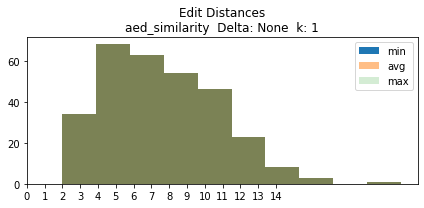

sim_func: 
<function aed_similarity at 0x0000015E79465C10>
<function semantic_delta at 0x0000015E79465550>


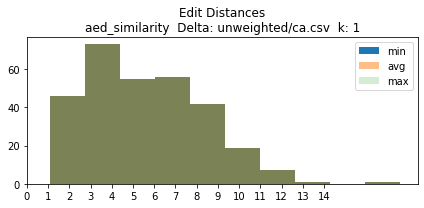

sim_func: 
<function aed_similarity at 0x0000015E79465C10>
<function semantic_delta at 0x0000015E79465550>


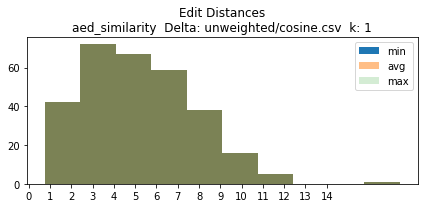

sim_func: 
<function aed_similarity at 0x0000015E79465C10>
<function semantic_delta at 0x0000015E79465550>


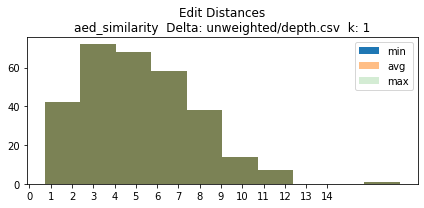

sim_func: 
<function aed_similarity at 0x0000015E79465C10>
<function semantic_delta at 0x0000015E79465550>


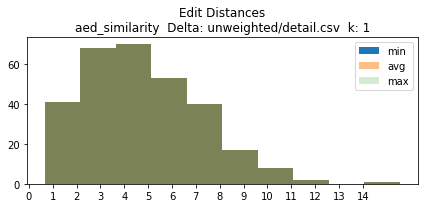

<function std_delta at 0x0000015E79465940>


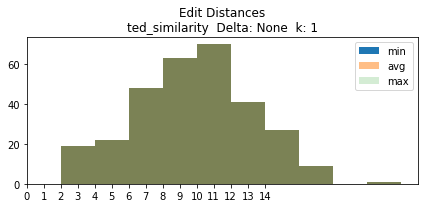

sim_func: 
<function ted_similarity at 0x0000015E794654C0>
<function semantic_delta at 0x0000015E79465550>


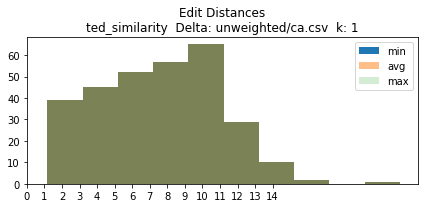

sim_func: 
<function ted_similarity at 0x0000015E794654C0>
<function semantic_delta at 0x0000015E79465550>


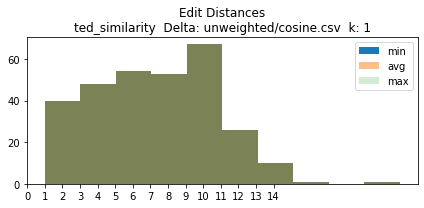

sim_func: 
<function ted_similarity at 0x0000015E794654C0>
<function semantic_delta at 0x0000015E79465550>


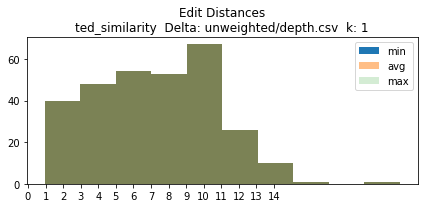

sim_func: 
<function ted_similarity at 0x0000015E794654C0>
<function semantic_delta at 0x0000015E79465550>


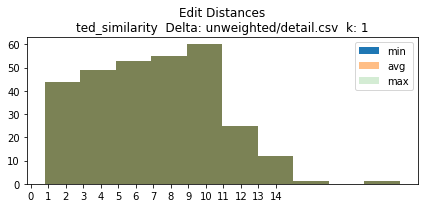

<function std_delta at 0x0000015E79465940>


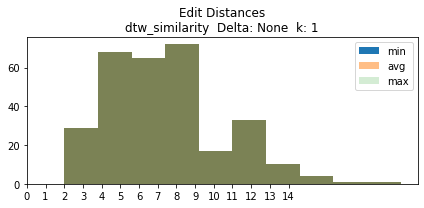

sim_func: 
<function dtw_similarity at 0x0000015E79465CA0>
<function semantic_delta at 0x0000015E79465550>


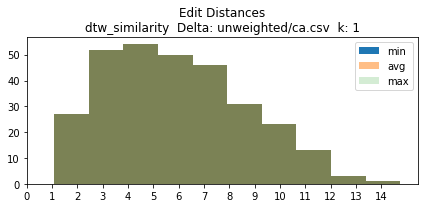

sim_func: 
<function dtw_similarity at 0x0000015E79465CA0>
<function semantic_delta at 0x0000015E79465550>


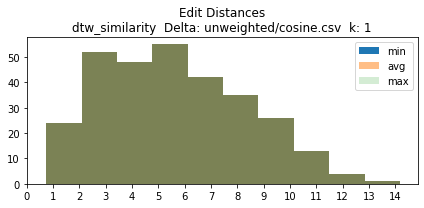

sim_func: 
<function dtw_similarity at 0x0000015E79465CA0>
<function semantic_delta at 0x0000015E79465550>


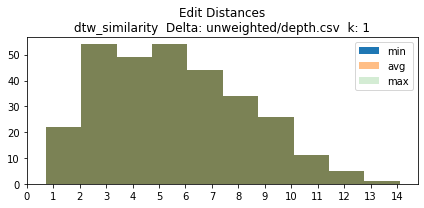

sim_func: 
<function dtw_similarity at 0x0000015E79465CA0>
<function semantic_delta at 0x0000015E79465550>


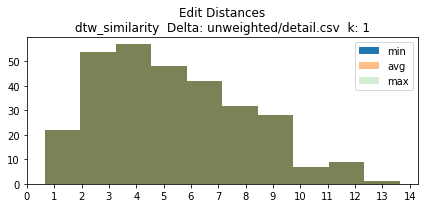

<function std_delta at 0x0000015E79465940>


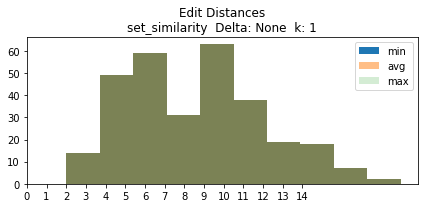

sim_func: 
<function set_similarity at 0x0000015E794658B0>
<function semantic_delta at 0x0000015E79465550>


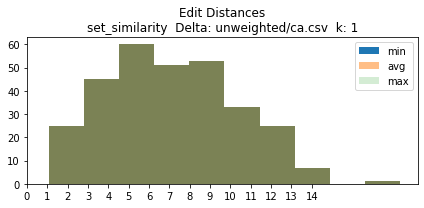

sim_func: 
<function set_similarity at 0x0000015E794658B0>
<function semantic_delta at 0x0000015E79465550>


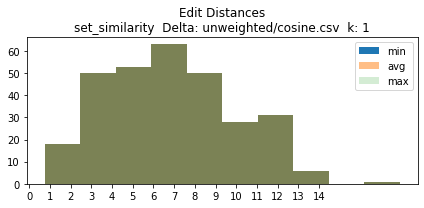

sim_func: 
<function set_similarity at 0x0000015E794658B0>
<function semantic_delta at 0x0000015E79465550>


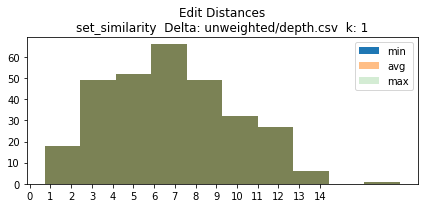

sim_func: 
<function set_similarity at 0x0000015E794658B0>
<function semantic_delta at 0x0000015E79465550>


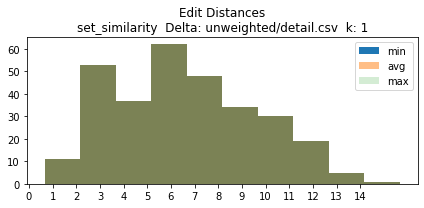

<function std_delta at 0x0000015E79465940>


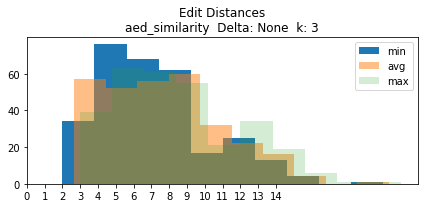

sim_func: 
<function aed_similarity at 0x0000015E79465C10>
<function semantic_delta at 0x0000015E79465550>


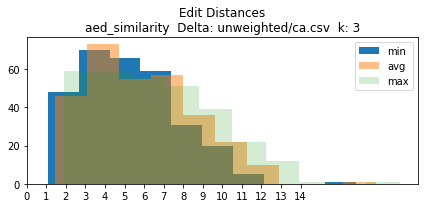

sim_func: 
<function aed_similarity at 0x0000015E79465C10>
<function semantic_delta at 0x0000015E79465550>


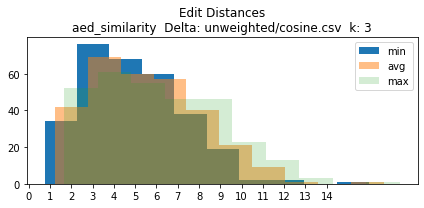

sim_func: 
<function aed_similarity at 0x0000015E79465C10>
<function semantic_delta at 0x0000015E79465550>


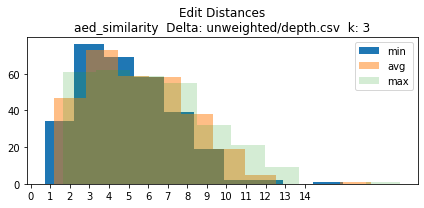

sim_func: 
<function aed_similarity at 0x0000015E79465C10>
<function semantic_delta at 0x0000015E79465550>


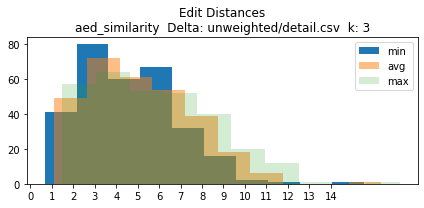

<function std_delta at 0x0000015E79465940>


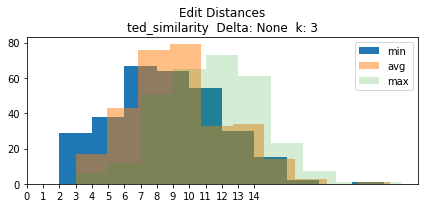

sim_func: 
<function ted_similarity at 0x0000015E794654C0>
<function semantic_delta at 0x0000015E79465550>


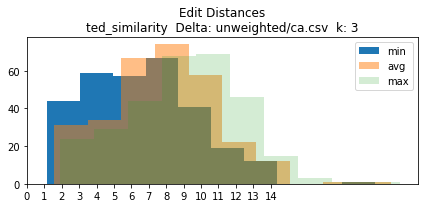

sim_func: 
<function ted_similarity at 0x0000015E794654C0>
<function semantic_delta at 0x0000015E79465550>


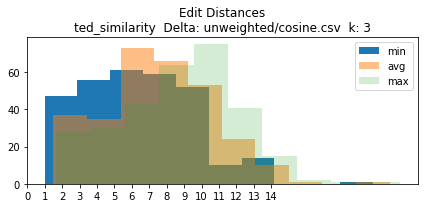

sim_func: 
<function ted_similarity at 0x0000015E794654C0>
<function semantic_delta at 0x0000015E79465550>


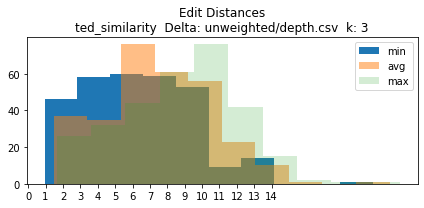

sim_func: 
<function ted_similarity at 0x0000015E794654C0>
<function semantic_delta at 0x0000015E79465550>


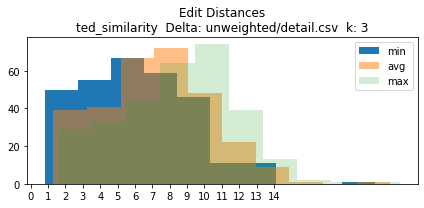

<function std_delta at 0x0000015E79465940>


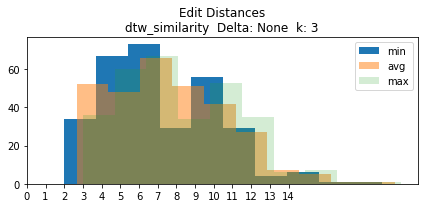

sim_func: 
<function dtw_similarity at 0x0000015E79465CA0>
<function semantic_delta at 0x0000015E79465550>


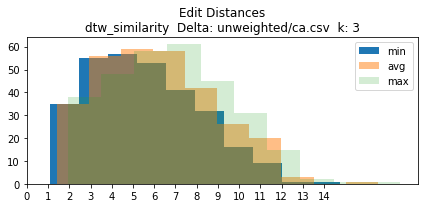

sim_func: 
<function dtw_similarity at 0x0000015E79465CA0>
<function semantic_delta at 0x0000015E79465550>


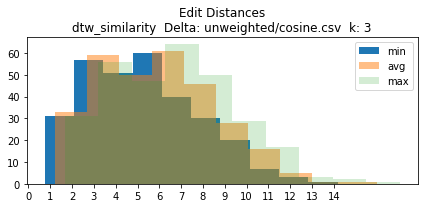

sim_func: 
<function dtw_similarity at 0x0000015E79465CA0>
<function semantic_delta at 0x0000015E79465550>


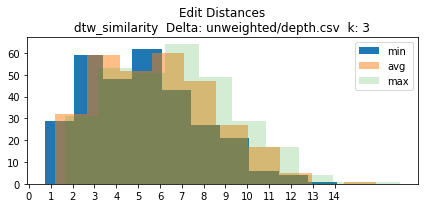

sim_func: 
<function dtw_similarity at 0x0000015E79465CA0>
<function semantic_delta at 0x0000015E79465550>


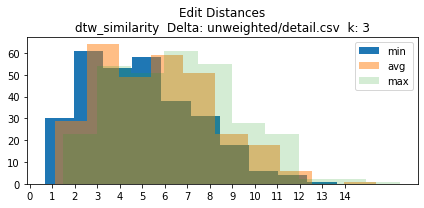

<function std_delta at 0x0000015E79465940>


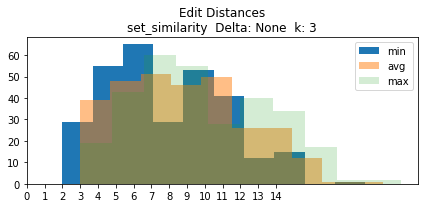

sim_func: 
<function set_similarity at 0x0000015E794658B0>
<function semantic_delta at 0x0000015E79465550>


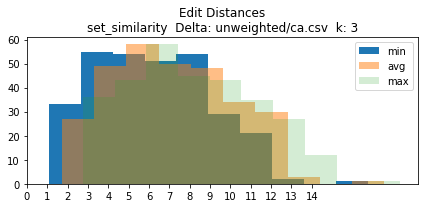

sim_func: 
<function set_similarity at 0x0000015E794658B0>
<function semantic_delta at 0x0000015E79465550>


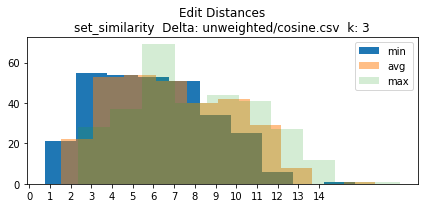

sim_func: 
<function set_similarity at 0x0000015E794658B0>
<function semantic_delta at 0x0000015E79465550>


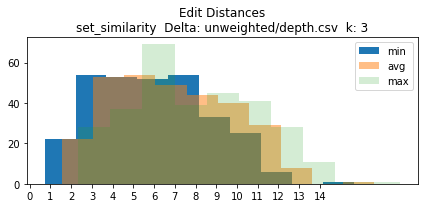

sim_func: 
<function set_similarity at 0x0000015E794658B0>
<function semantic_delta at 0x0000015E79465550>


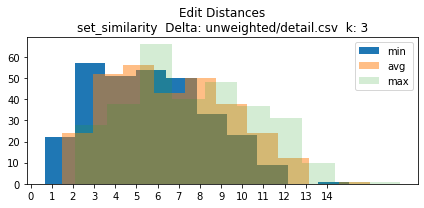

<function std_delta at 0x0000015E79465940>


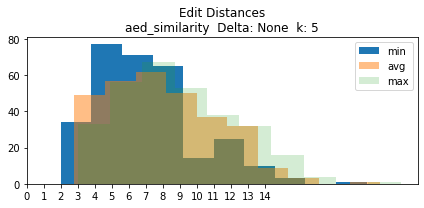

sim_func: 
<function aed_similarity at 0x0000015E79465C10>
<function semantic_delta at 0x0000015E79465550>


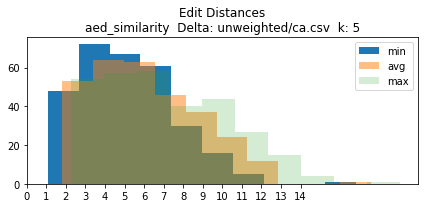

sim_func: 
<function aed_similarity at 0x0000015E79465C10>
<function semantic_delta at 0x0000015E79465550>


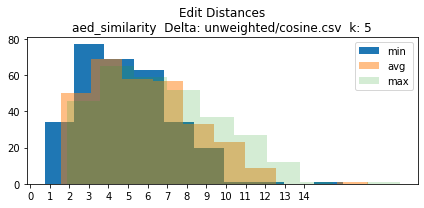

sim_func: 
<function aed_similarity at 0x0000015E79465C10>
<function semantic_delta at 0x0000015E79465550>


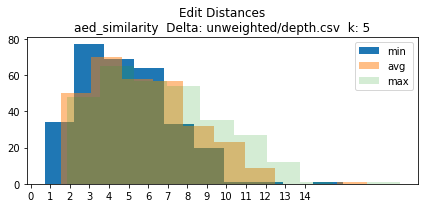

sim_func: 
<function aed_similarity at 0x0000015E79465C10>
<function semantic_delta at 0x0000015E79465550>


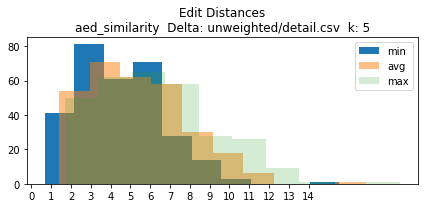

<function std_delta at 0x0000015E79465940>


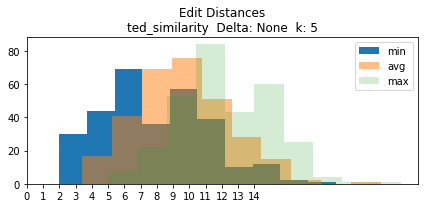

sim_func: 
<function ted_similarity at 0x0000015E794654C0>
<function semantic_delta at 0x0000015E79465550>


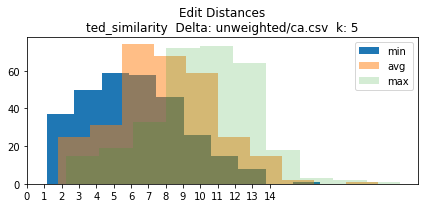

sim_func: 
<function ted_similarity at 0x0000015E794654C0>
<function semantic_delta at 0x0000015E79465550>


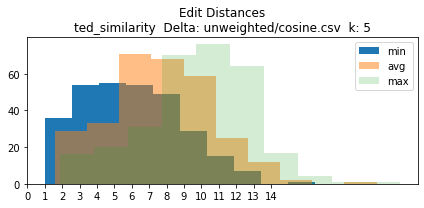

sim_func: 
<function ted_similarity at 0x0000015E794654C0>
<function semantic_delta at 0x0000015E79465550>


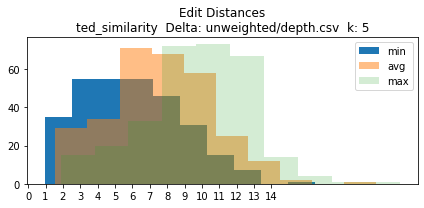

sim_func: 
<function ted_similarity at 0x0000015E794654C0>
<function semantic_delta at 0x0000015E79465550>


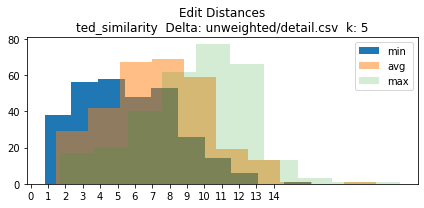

<function std_delta at 0x0000015E79465940>


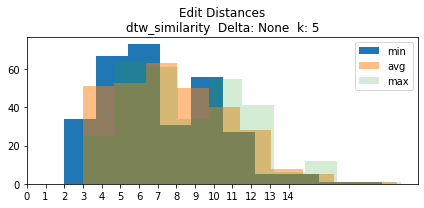

sim_func: 
<function dtw_similarity at 0x0000015E79465CA0>
<function semantic_delta at 0x0000015E79465550>


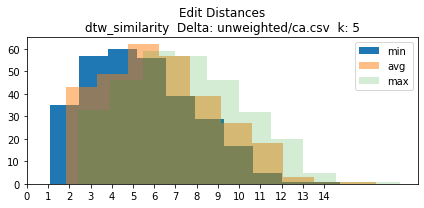

sim_func: 
<function dtw_similarity at 0x0000015E79465CA0>
<function semantic_delta at 0x0000015E79465550>


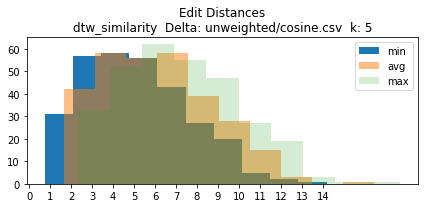

sim_func: 
<function dtw_similarity at 0x0000015E79465CA0>
<function semantic_delta at 0x0000015E79465550>


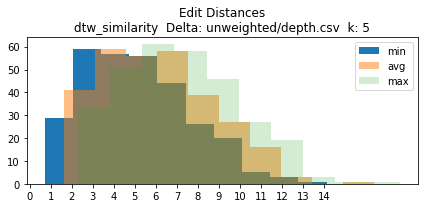

sim_func: 
<function dtw_similarity at 0x0000015E79465CA0>
<function semantic_delta at 0x0000015E79465550>


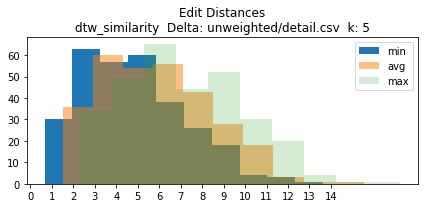

<function std_delta at 0x0000015E79465940>


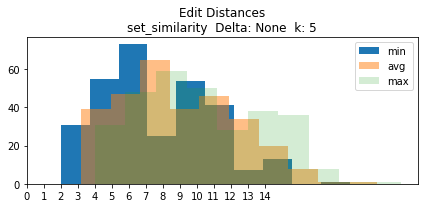

sim_func: 
<function set_similarity at 0x0000015E794658B0>
<function semantic_delta at 0x0000015E79465550>


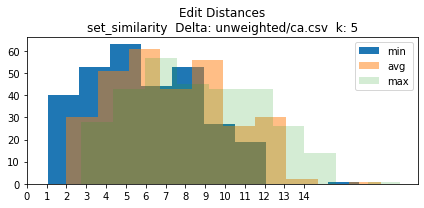

sim_func: 
<function set_similarity at 0x0000015E794658B0>
<function semantic_delta at 0x0000015E79465550>


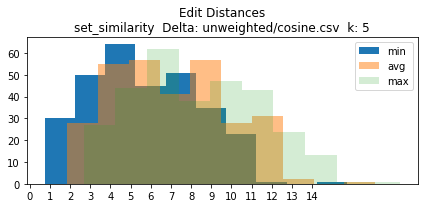

sim_func: 
<function set_similarity at 0x0000015E794658B0>
<function semantic_delta at 0x0000015E79465550>


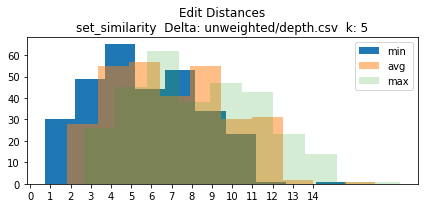

sim_func: 
<function set_similarity at 0x0000015E794658B0>
<function semantic_delta at 0x0000015E79465550>


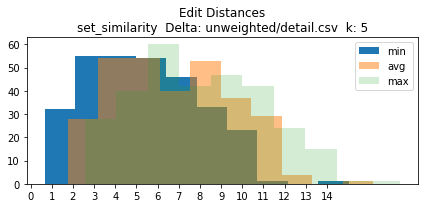

<function std_delta at 0x0000015E79465940>


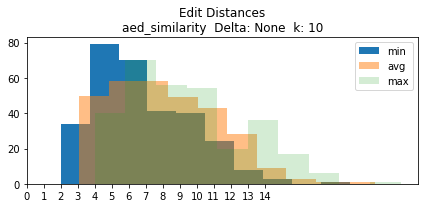

sim_func: 
<function aed_similarity at 0x0000015E79465C10>
<function semantic_delta at 0x0000015E79465550>


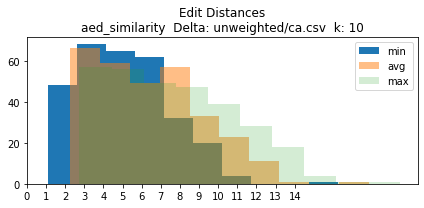

sim_func: 
<function aed_similarity at 0x0000015E79465C10>
<function semantic_delta at 0x0000015E79465550>


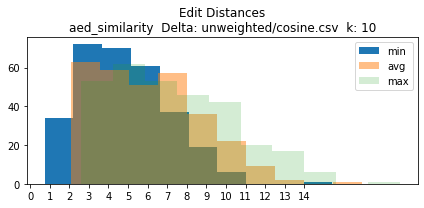

sim_func: 
<function aed_similarity at 0x0000015E79465C10>
<function semantic_delta at 0x0000015E79465550>


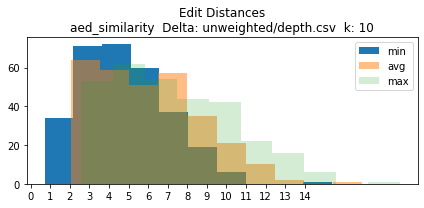

sim_func: 
<function aed_similarity at 0x0000015E79465C10>
<function semantic_delta at 0x0000015E79465550>


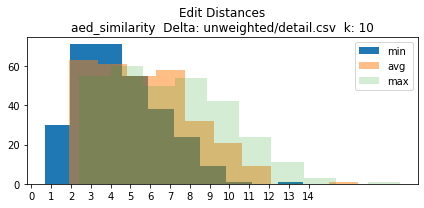

<function std_delta at 0x0000015E79465940>


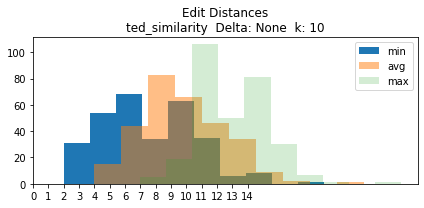

sim_func: 
<function ted_similarity at 0x0000015E794654C0>
<function semantic_delta at 0x0000015E79465550>


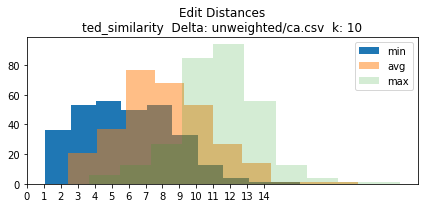

sim_func: 
<function ted_similarity at 0x0000015E794654C0>
<function semantic_delta at 0x0000015E79465550>


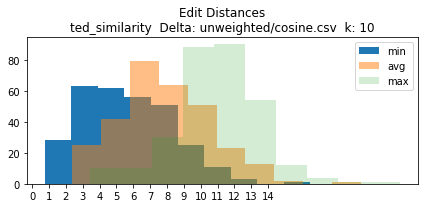

sim_func: 
<function ted_similarity at 0x0000015E794654C0>
<function semantic_delta at 0x0000015E79465550>


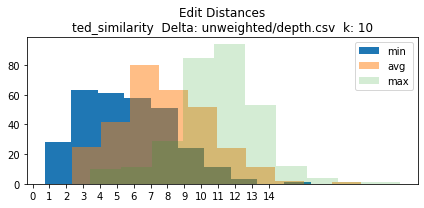

sim_func: 
<function ted_similarity at 0x0000015E794654C0>
<function semantic_delta at 0x0000015E79465550>


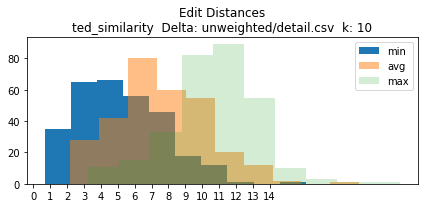

<function std_delta at 0x0000015E79465940>


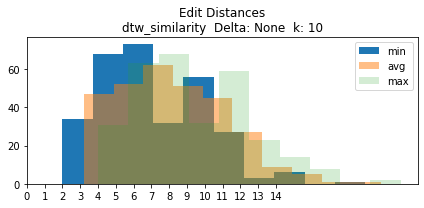

sim_func: 
<function dtw_similarity at 0x0000015E79465CA0>
<function semantic_delta at 0x0000015E79465550>


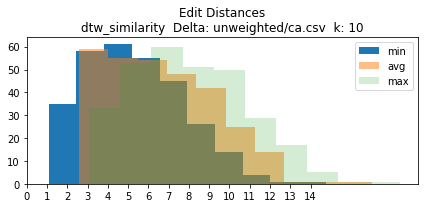

sim_func: 
<function dtw_similarity at 0x0000015E79465CA0>
<function semantic_delta at 0x0000015E79465550>


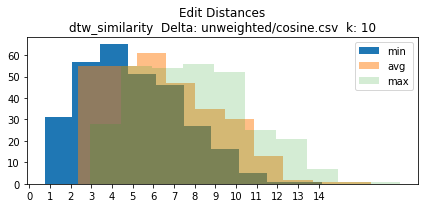

sim_func: 
<function dtw_similarity at 0x0000015E79465CA0>
<function semantic_delta at 0x0000015E79465550>


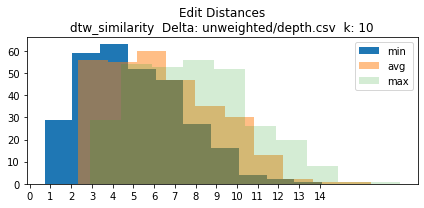

sim_func: 
<function dtw_similarity at 0x0000015E79465CA0>
<function semantic_delta at 0x0000015E79465550>


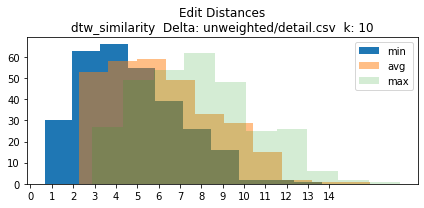

<function std_delta at 0x0000015E79465940>


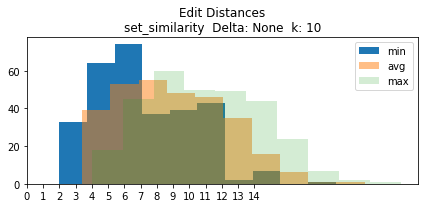

sim_func: 
<function set_similarity at 0x0000015E794658B0>
<function semantic_delta at 0x0000015E79465550>


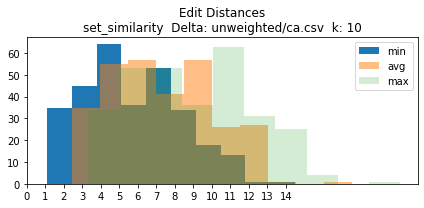

sim_func: 
<function set_similarity at 0x0000015E794658B0>
<function semantic_delta at 0x0000015E79465550>


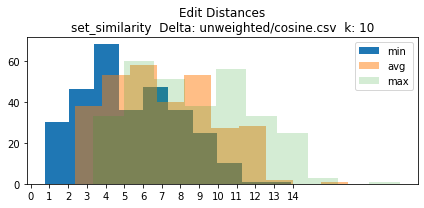

sim_func: 
<function set_similarity at 0x0000015E794658B0>
<function semantic_delta at 0x0000015E79465550>


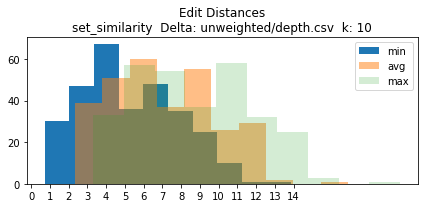

sim_func: 
<function set_similarity at 0x0000015E794658B0>
<function semantic_delta at 0x0000015E79465550>


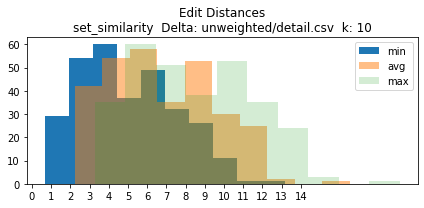

<function std_delta at 0x0000015E79465940>


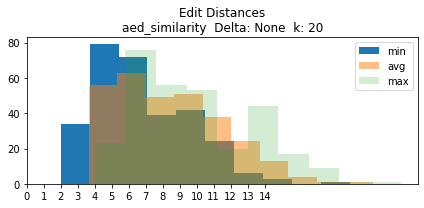

sim_func: 
<function aed_similarity at 0x0000015E79465C10>
<function semantic_delta at 0x0000015E79465550>


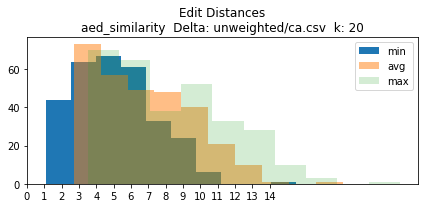

sim_func: 
<function aed_similarity at 0x0000015E79465C10>
<function semantic_delta at 0x0000015E79465550>


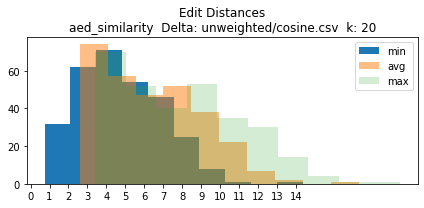

sim_func: 
<function aed_similarity at 0x0000015E79465C10>
<function semantic_delta at 0x0000015E79465550>


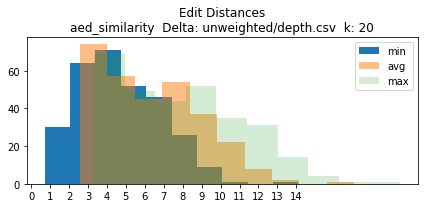

sim_func: 
<function aed_similarity at 0x0000015E79465C10>
<function semantic_delta at 0x0000015E79465550>


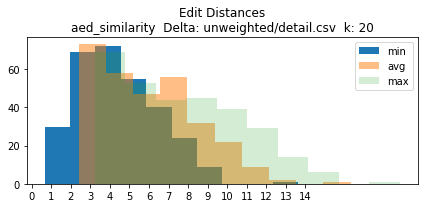

<function std_delta at 0x0000015E79465940>


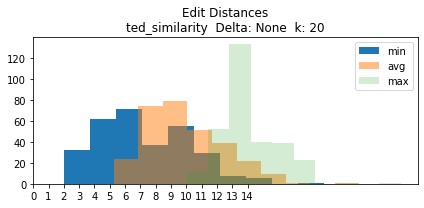

sim_func: 
<function ted_similarity at 0x0000015E794654C0>
<function semantic_delta at 0x0000015E79465550>


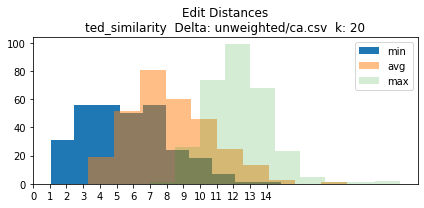

sim_func: 
<function ted_similarity at 0x0000015E794654C0>
<function semantic_delta at 0x0000015E79465550>


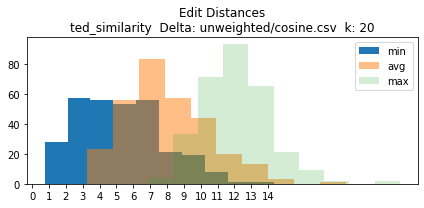

sim_func: 
<function ted_similarity at 0x0000015E794654C0>
<function semantic_delta at 0x0000015E79465550>


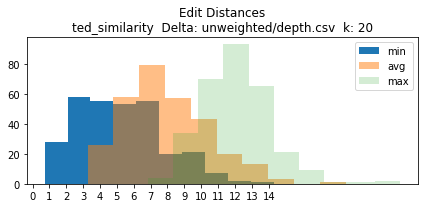

sim_func: 
<function ted_similarity at 0x0000015E794654C0>
<function semantic_delta at 0x0000015E79465550>


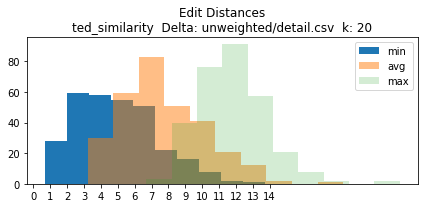

<function std_delta at 0x0000015E79465940>


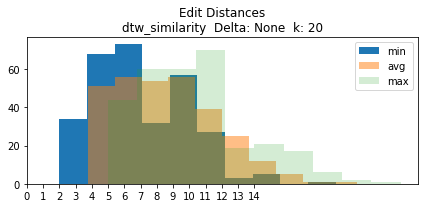

sim_func: 
<function dtw_similarity at 0x0000015E79465CA0>
<function semantic_delta at 0x0000015E79465550>


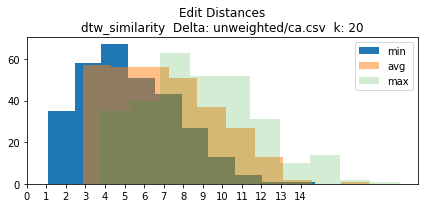

sim_func: 
<function dtw_similarity at 0x0000015E79465CA0>
<function semantic_delta at 0x0000015E79465550>


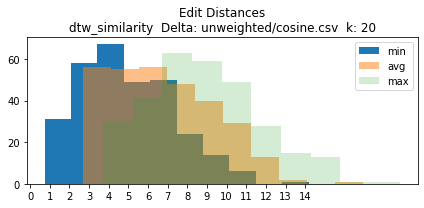

sim_func: 
<function dtw_similarity at 0x0000015E79465CA0>
<function semantic_delta at 0x0000015E79465550>


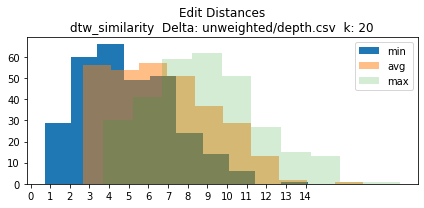

sim_func: 
<function dtw_similarity at 0x0000015E79465CA0>
<function semantic_delta at 0x0000015E79465550>


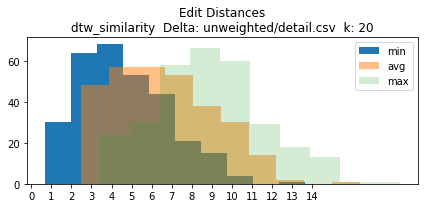

<function std_delta at 0x0000015E79465940>


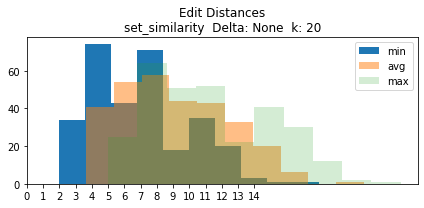

sim_func: 
<function set_similarity at 0x0000015E794658B0>
<function semantic_delta at 0x0000015E79465550>


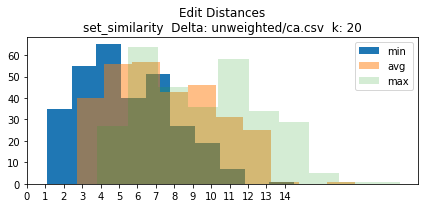

sim_func: 
<function set_similarity at 0x0000015E794658B0>
<function semantic_delta at 0x0000015E79465550>


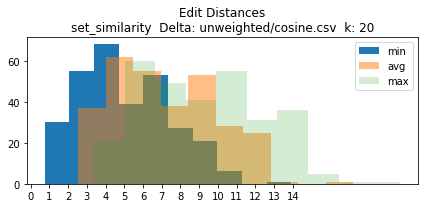

sim_func: 
<function set_similarity at 0x0000015E794658B0>
<function semantic_delta at 0x0000015E79465550>


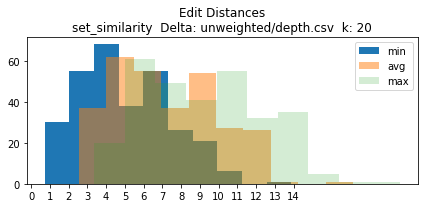

sim_func: 
<function set_similarity at 0x0000015E794658B0>
<function semantic_delta at 0x0000015E79465550>


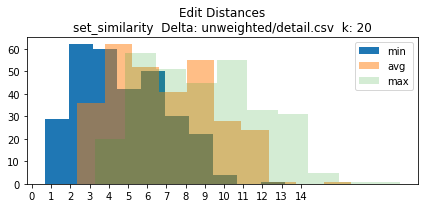

In [48]:
results = gridSearch(casebase)
#results.to_csv('results.csv')

In [51]:
results.to_csv('results.csv')

In [48]:
results = pd.read_csv('results.csv')  

In [49]:
results

,Unnamed: 0,k,similarity_function,distance_function,avg,min,max
0,0,1,aed_similarity,None,7.363333,7.363333,7.363333
1,1,1,aed_similarity,unweighted/ca.csv,5.615833,5.615833,5.615833
2,2,1,aed_similarity,unweighted/cosine.csv,5.224286,5.224286,5.224286
3,3,1,aed_similarity,unweighted/depth.csv,5.181870,5.181870,5.181870
4,4,1,aed_similarity,unweighted/detail.csv,4.794487,4.794487,4.794487
...,...,...,...,...,...,...,...
95,95,20,set_similarity,None,9.093000,6.926667,11.246667
96,96,20,set_similarity,unweighted/ca.csv,7.478597,5.396667,9.484167
97,97,20,set_similarity,unweighted/cosine.csv,7.210500,5.087957,9.238053
98,98,20,set_similarity,unweighted/depth.csv,7.182367,5.058431,9.206357


In [50]:
n=300

In [51]:
def plotKresults(sim_fun, distance_fun, color):
    plt.figure(figsize=(12,6), tight_layout=True)
    sim_fun_series = results.loc[results['similarity_function']==sim_fun]
    distance_series = sim_fun_series.loc[sim_fun_series['distance_function']==distance_fun]
    plt.title("Edit Distances\n" + sim_fun+ "  Delta: " + distance_fun)
    # plt.ylim(0, 50)
    plt.ylim(-5, 50)
    plt.plot(k_values, distance_series['avg'], color=color, label=distance_fun)
    upper_limit = distance_series['max']
    lower_limit = distance_series['min']
    plt.fill_between(k_values, lower_limit, upper_limit, color=color, alpha=.1)
    plt.xticks(k_values)
    plt.ylabel("edit distance"), plt.legend(loc="best")
    plt.show()
    print(distance_series['avg'])

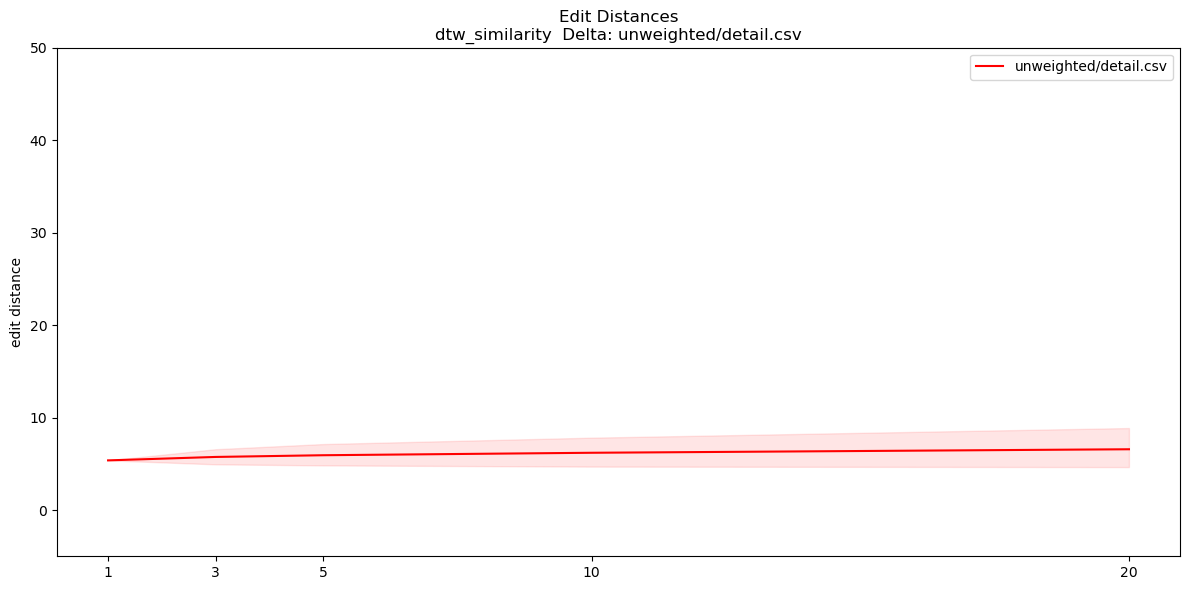

14    5.371823
34    5.742952
54    5.928268
74    6.194886
94    6.574193
Name: avg, dtype: float64


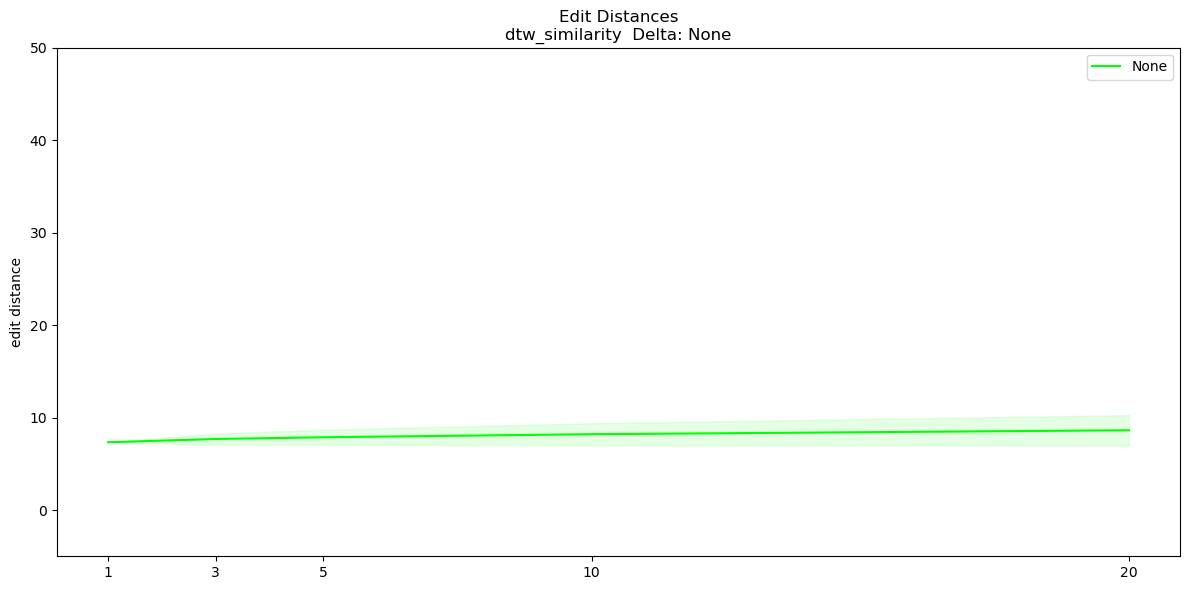

10    7.333333
30    7.683333
50    7.870667
70    8.201667
90    8.628833
Name: avg, dtype: float64


In [52]:
plotKresults('dtw_similarity','unweighted/detail.csv', '#ff0000')
plotKresults('dtw_similarity','None', '#00ff00')

In [63]:
def plotSimFun(sim_fun, distance_functions):
    plt.figure(figsize=(12,6), tight_layout=True)
    sim_fun_series = results.loc[results['similarity_function']==sim_fun]
    plt.title("Similarity Function: " + sim_fun)
    #plt.ylim(5, 25)
    plt.ylim(-5, 50)
    plt.xticks(k_values)
    plt.ylabel("edit distance")
    colors = list(mcolors.TABLEAU_COLORS.values())
    i = 0
    for distance_fun in distance_functions:
        color = colors[i]
        i+=1
        distance_series = sim_fun_series.loc[sim_fun_series['distance_function']==distance_fun]
        plt.plot(k_values, distance_series['avg'], color=color, label=distance_fun.strip(".csv"))
        upper_limit = distance_series['max']
        lower_limit = distance_series['min']
        plt.fill_between(k_values, lower_limit, upper_limit, color=color, alpha=.1)
    plt.legend(loc="best")
    plt.savefig("similariy_semantic_impact"+sim_fun+".png")
    plt.show()


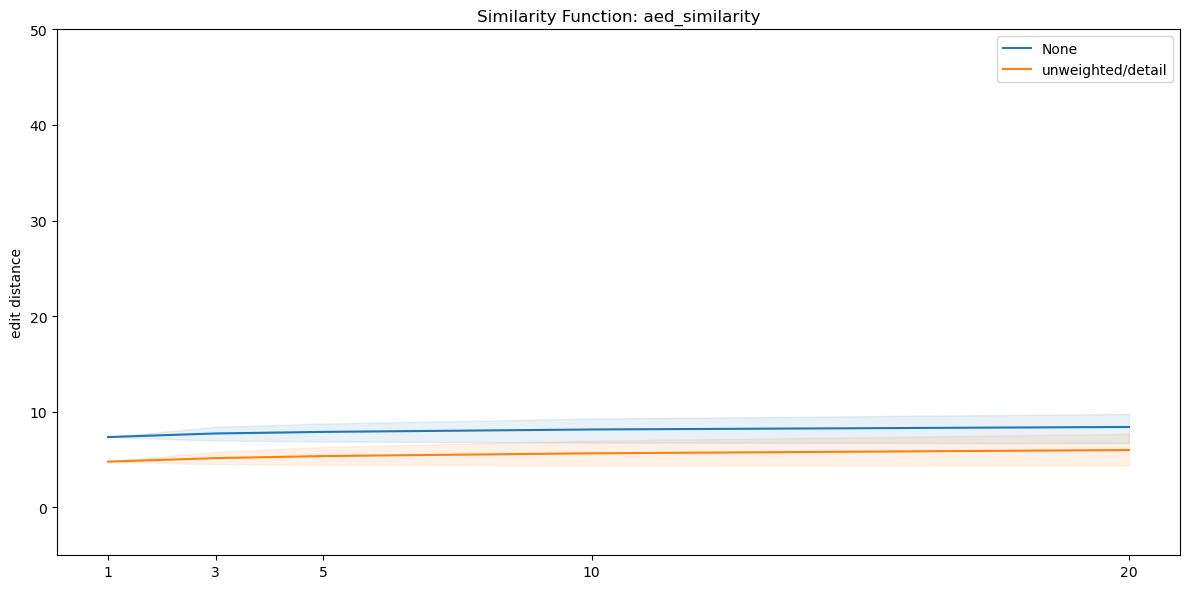

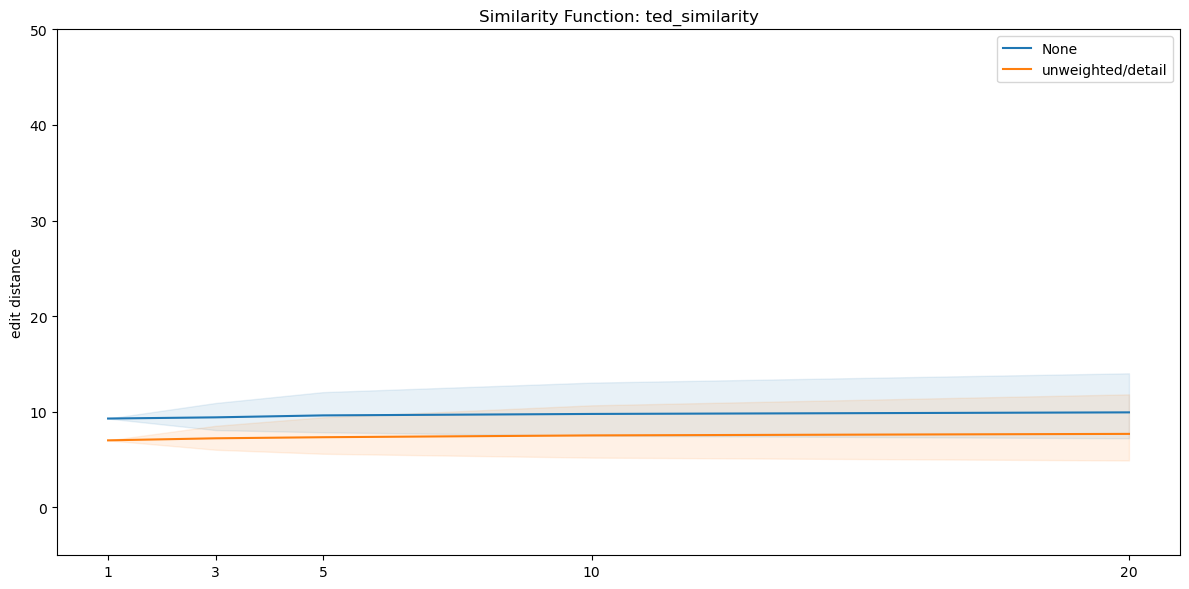

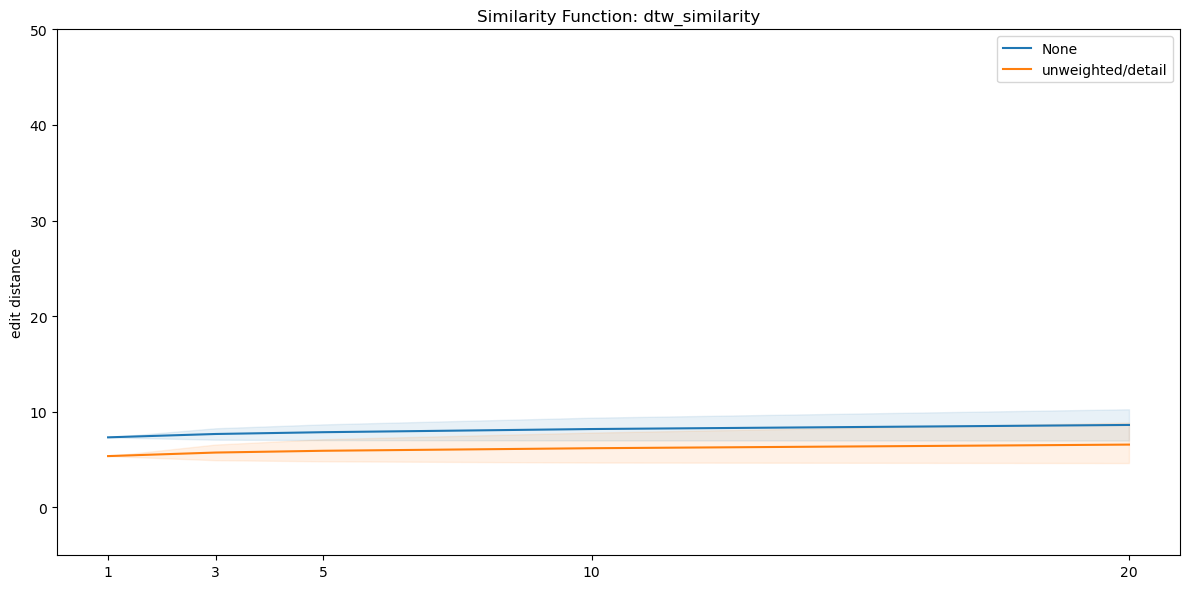

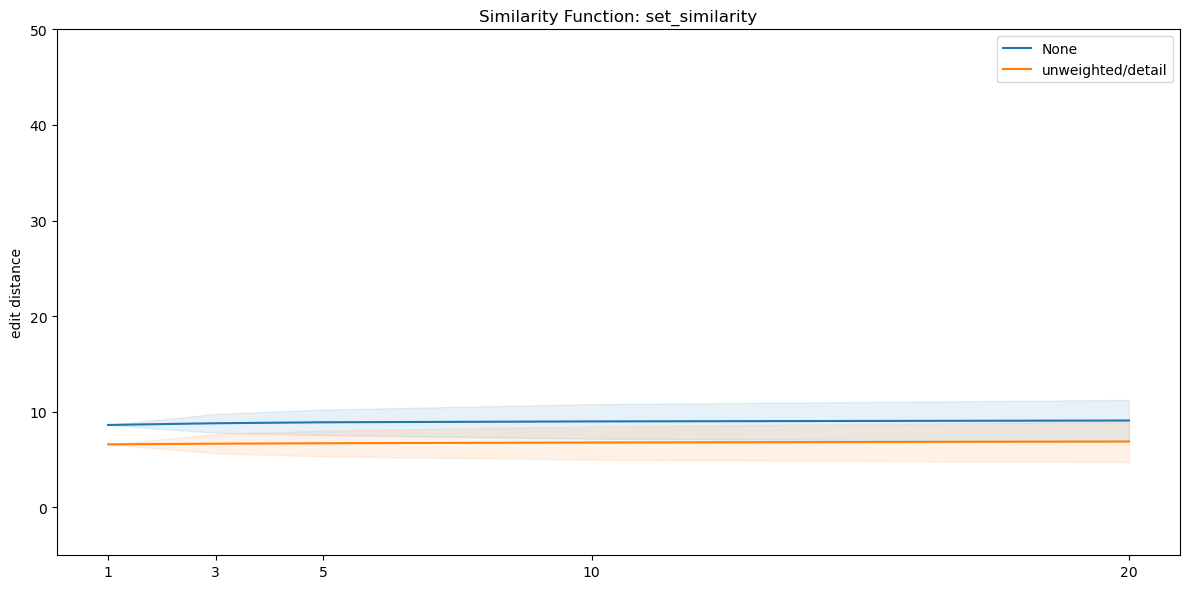

In [64]:
for sim in similarity_functions:
    plotSimFun(sim.__name__,['None','unweighted/detail.csv'])

In [65]:
def plotSimFun(sim_fun, distance_functions):
    plt.figure(figsize=(7,4), tight_layout=True)
    sim_fun_series = results.loc[results['similarity_function']==sim_fun]
    plt.title("Structural Similarity: " + sim_fun)
    plt.ylim(3.5, 22.5)
    plt.xticks(k_values)
    plt.ylabel("Levenshtein Similarity")
    colors = list(mcolors.TABLEAU_COLORS.values())
    i = 0
    for distance_fun in distance_functions:
        color = colors[i]
        i+=1
        distance_series = sim_fun_series.loc[sim_fun_series['distance_function']==distance_fun]
        title = distance_fun.strip(".csv").replace("wsim/","")
        if title=='ca':
            title = 'common attributes'
        plt.plot(k_values, distance_series['avg'], color=color, label=title, linewidth=2.5)
        upper_limit = distance_series['max']
        lower_limit = distance_series['min']
        plt.plot(k_values, upper_limit, color=color, alpha=.75, linestyle="dotted", linewidth=2)
        plt.plot(k_values, lower_limit, color=color, alpha=.75, linestyle="dotted", linewidth=2)
    plt.legend(loc="best")
    plt.savefig("similariy_semantic_impact_"+sim_fun+".png")
    plt.show()


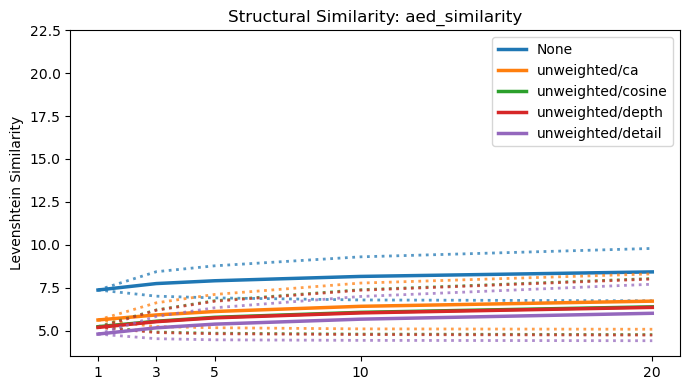

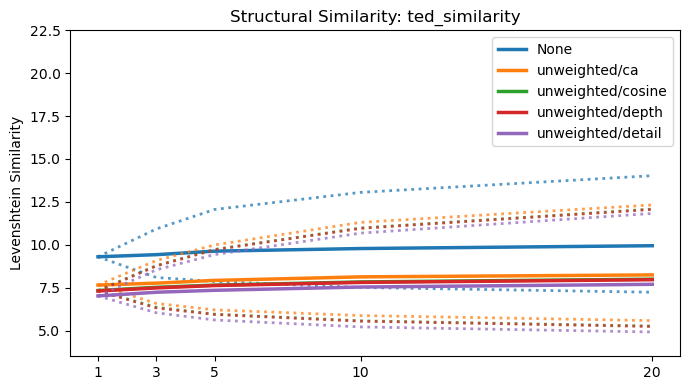

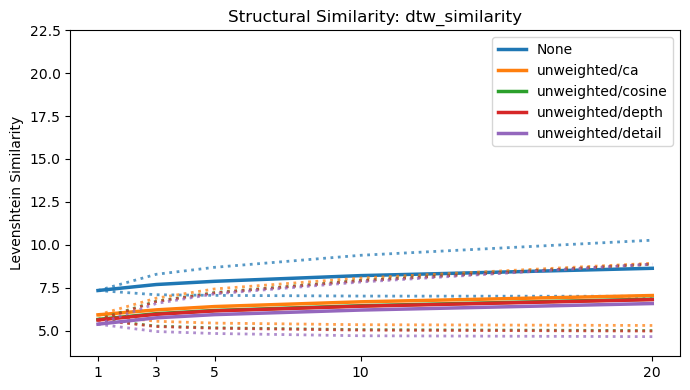

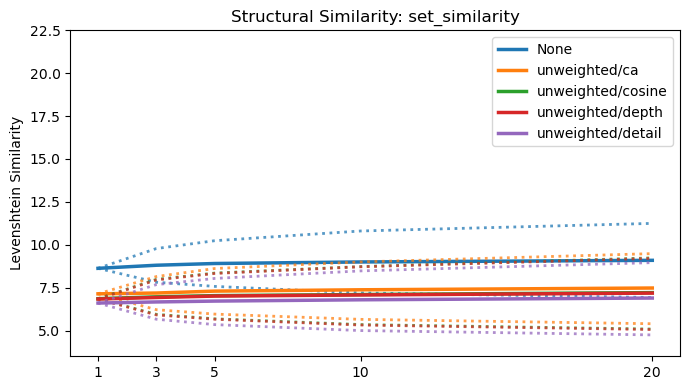

In [66]:
for sim in similarity_functions:
    plotSimFun(sim.__name__,distance_tables)

In [67]:
def plotDistFun(similarity_functions, distance_fun):
    plt.figure(figsize=(12,6), tight_layout=True)
    dist_fun_series = results.loc[results['distance_function']==distance_fun]
    plt.title("Distance Function: " + distance_fun.strip(".csv"))
    plt.ylim(3.5, 22.5)
    #plt.ylim(-5, 50)
    plt.xticks(k_values)
    plt.ylabel("edit distance")
    colors = list(mcolors.TABLEAU_COLORS.values())
    i = 0
    for sim_fun in similarity_functions:
        color = colors[i]
        i+=1
        series = dist_fun_series.loc[dist_fun_series['similarity_function']==sim_fun.__name__]
        plt.plot(k_values, series['avg'], color=color, label=sim_fun.__name__)
        upper_limit = series['max']
        lower_limit = series['min']
        plt.fill_between(k_values, lower_limit, upper_limit, color=color, alpha=.1)
    plt.legend(loc="best")
    plt.savefig("distance_analysis_"+distance_fun.strip(".csv").replace("/", "_" )+".png")
    plt.show()


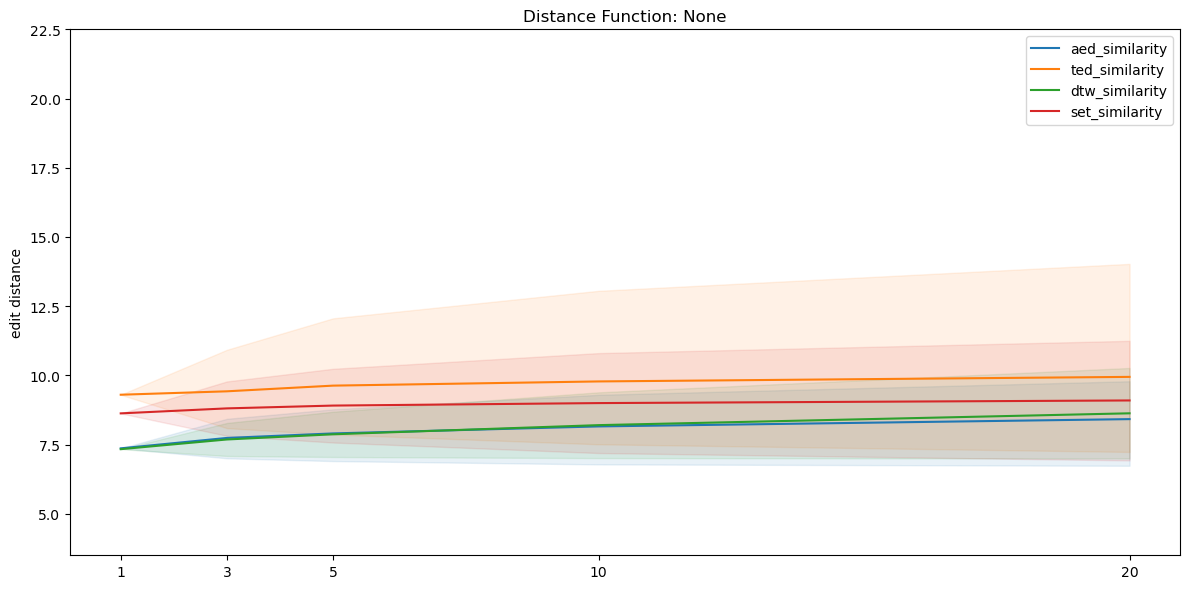

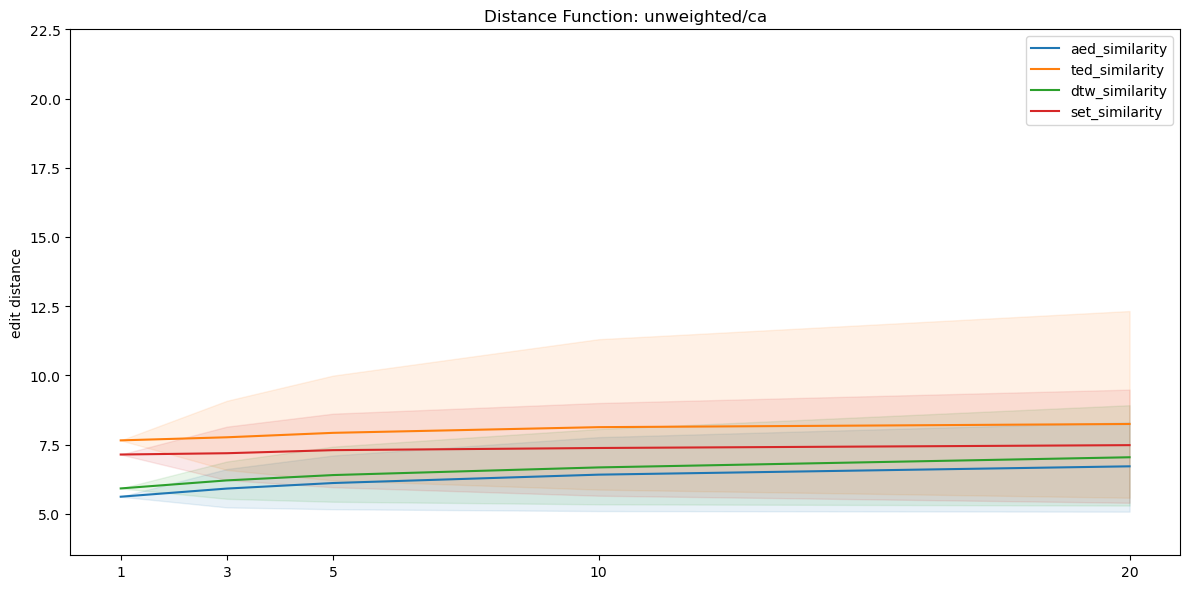

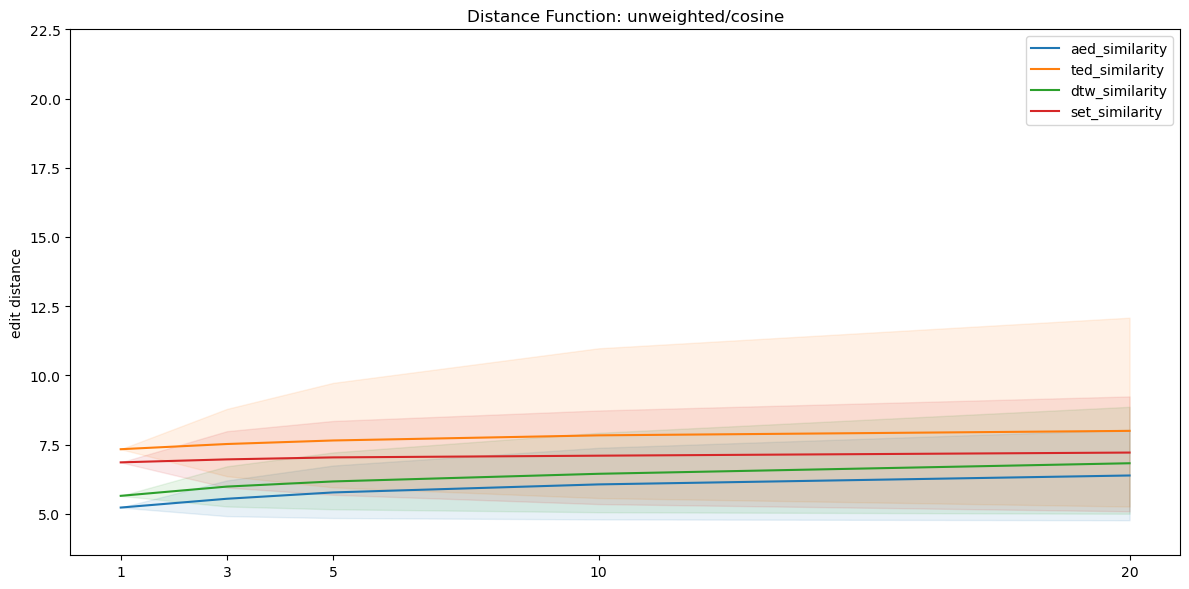

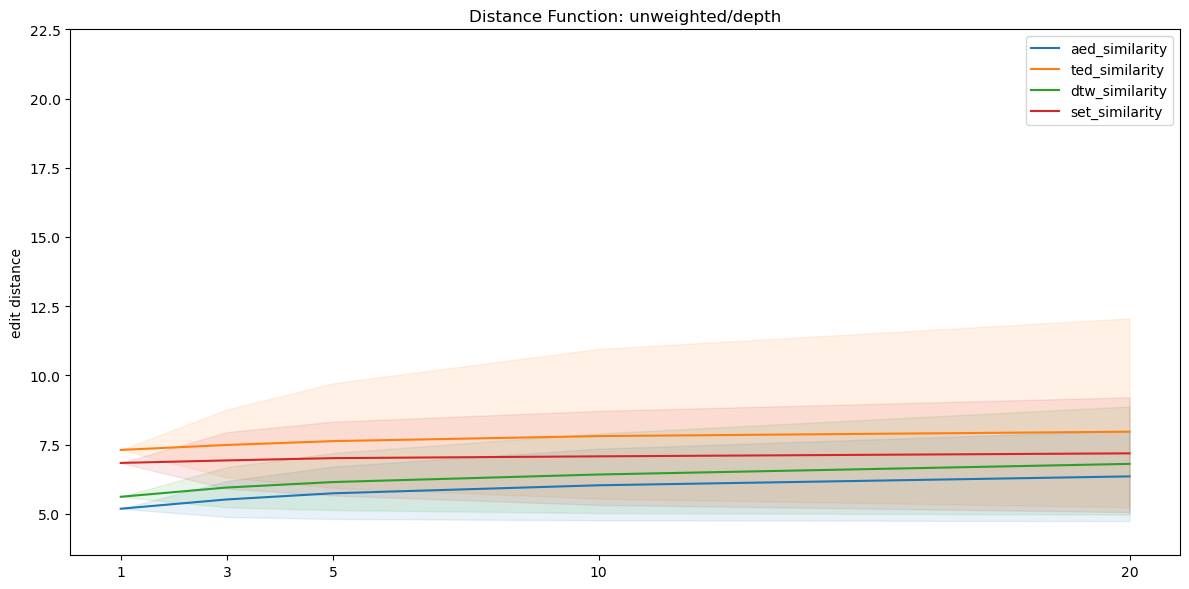

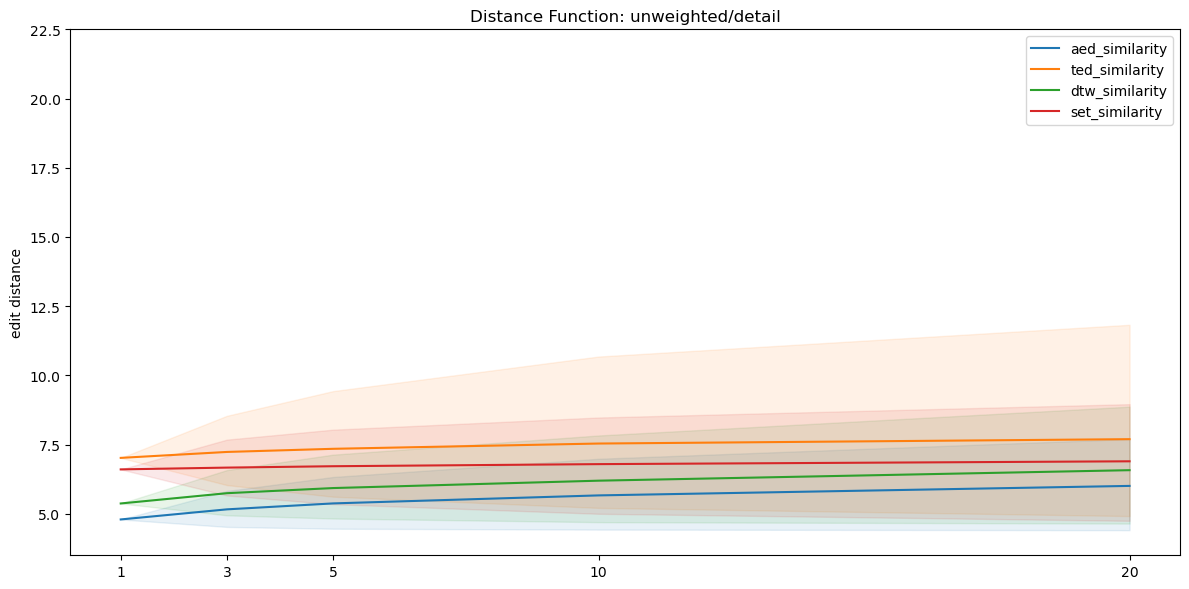

In [68]:
for distance_fun in distance_tables:
    plotDistFun(similarity_functions,distance_fun)

In [69]:
def plotDistFun(similarity_functions, distance_fun):
    plt.figure(figsize=(7,4), tight_layout=True)
    dist_fun_series = results.loc[results['distance_function']==distance_fun]
    title = distance_fun.strip(".csv").replace("wsim/","")
    if title=='ca':
        title = 'common attributes'
    plt.title("Semantic Similarity Explainers: " + title)
    plt.ylim(3.5, 15)
    plt.xticks(k_values)
    plt.ylabel("Levenshtein Similarity")
    colors = list(mcolors.TABLEAU_COLORS.values())
    i = 0
    for sim_fun in similarity_functions:
        color = colors[i]
        i+=1
        series = dist_fun_series.loc[dist_fun_series['similarity_function']==sim_fun.__name__]
        plt.plot(k_values, series['avg'], color=color, label=sim_fun.__name__, linewidth=2.5)
        upper_limit = series['max']
        lower_limit = series['min']
        #plt.fill_between(k_values, lower_limit, upper_limit, color=color, alpha=.1)
        plt.plot(k_values, upper_limit, color=color, alpha=.75, linestyle="dotted", linewidth=2)
        plt.plot(k_values, lower_limit, color=color, alpha=.75, linestyle="dotted", linewidth=2)
    plt.legend(loc="best")
    plt.savefig("distance_analysis_"+distance_fun.strip(".csv").replace("/", "_" )+".png")
    plt.show()


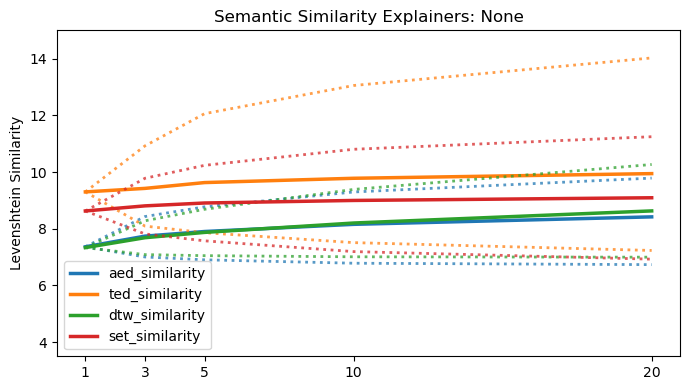

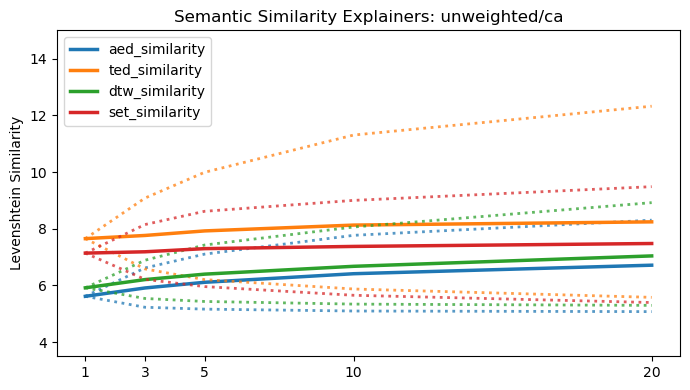

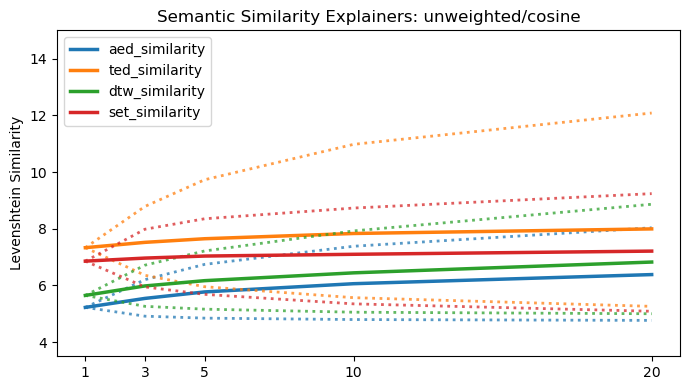

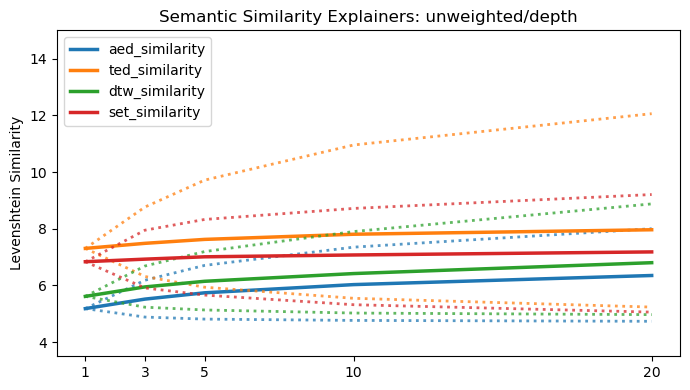

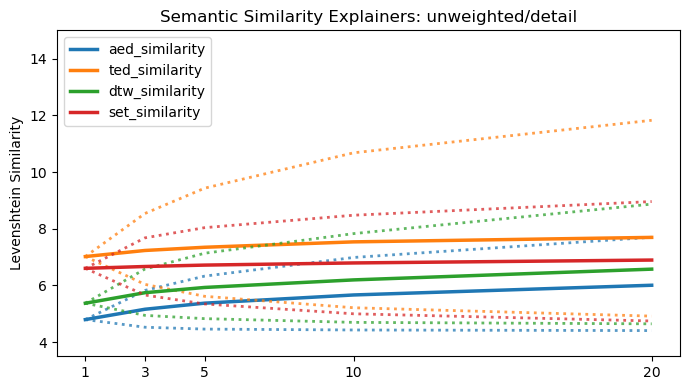

In [70]:
for distance_fun in distance_tables:
    plotDistFun(similarity_functions,distance_fun)

In [71]:
def plotKseries(sim_fun, distance_functions):
    plt.figure(figsize=(12,6), tight_layout=True)
    sim_fun_series = results.loc[results['similarity_function']==sim_fun]
    plt.title("Similarity Function: " + sim_fun)
    #plt.ylim(5, 20)
    plt.ylim(3.5, 15)
    xvalues = np.arange(len(distance_functions))
    plt.xticks(xvalues,distance_functions)
    plt.ylabel("edit distance")
    colors = list(mcolors.TABLEAU_COLORS.values())
    i = 0
    for k in k_values:
        color = colors[i]
        i+=1
        series = sim_fun_series.loc[sim_fun_series['k']==k]
        plt.plot(xvalues, series['avg'], color=color, label=k)
        upper_limit = series['max']
        lower_limit = series['min']
        plt.fill_between(xvalues, lower_limit, upper_limit, color=color, alpha=.1)
    plt.legend(loc="best")
    plt.savefig("similarity_analysis_"+sim_fun+".png")
    plt.show()


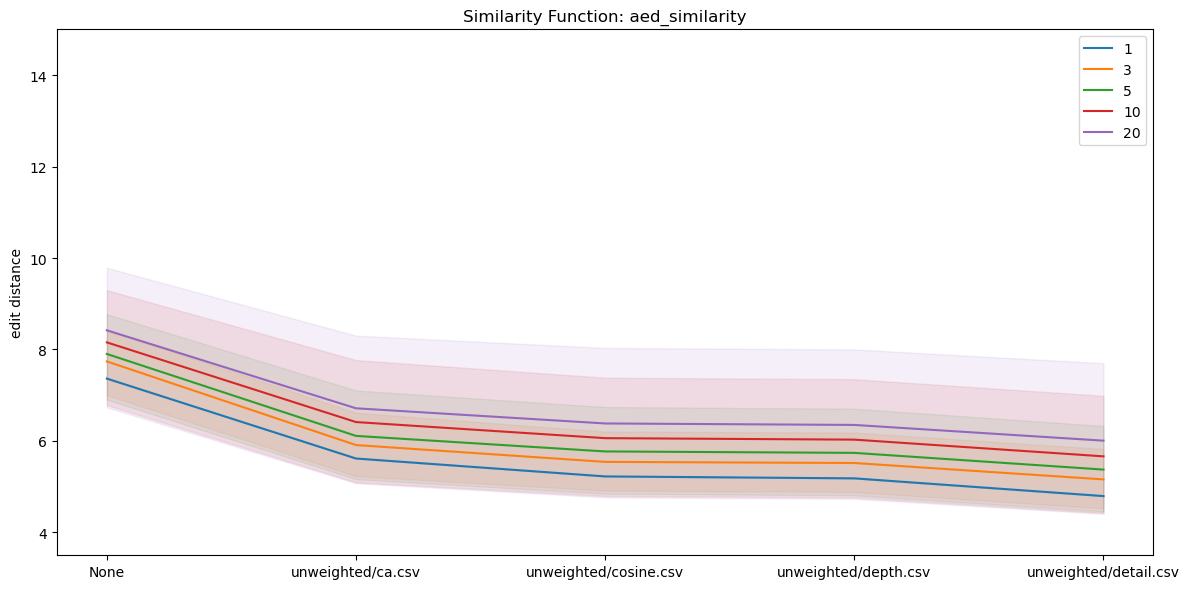

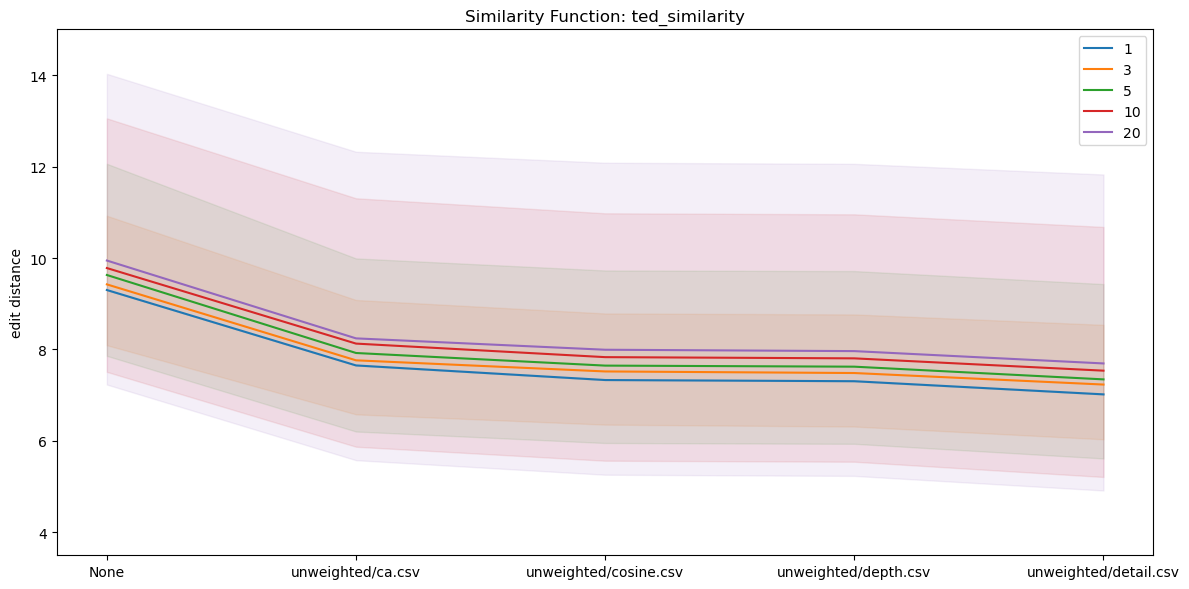

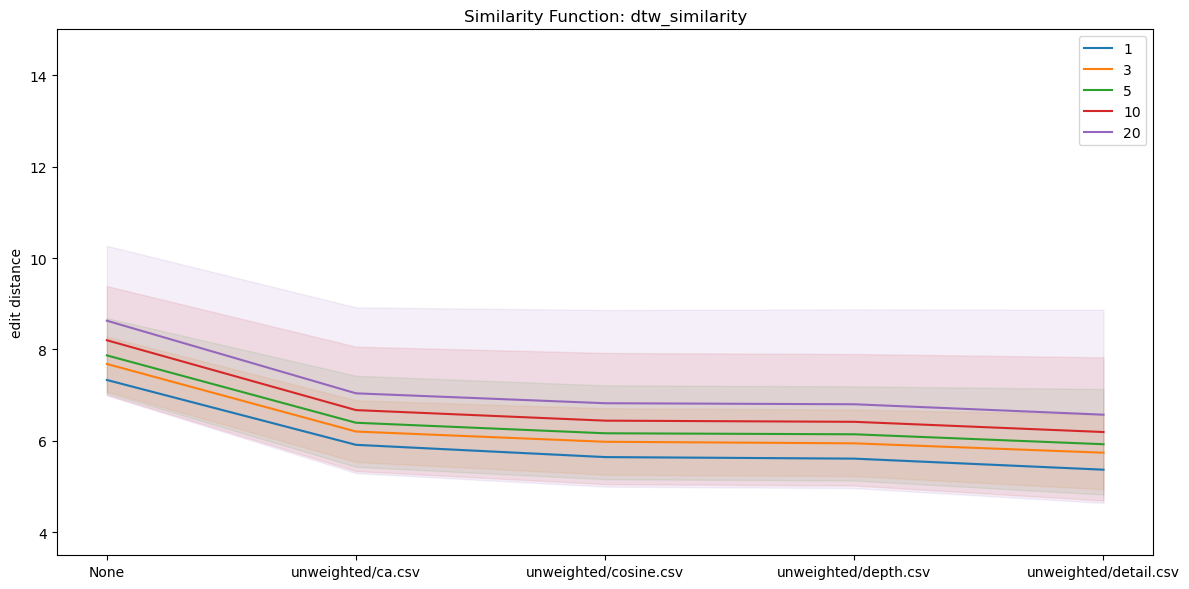

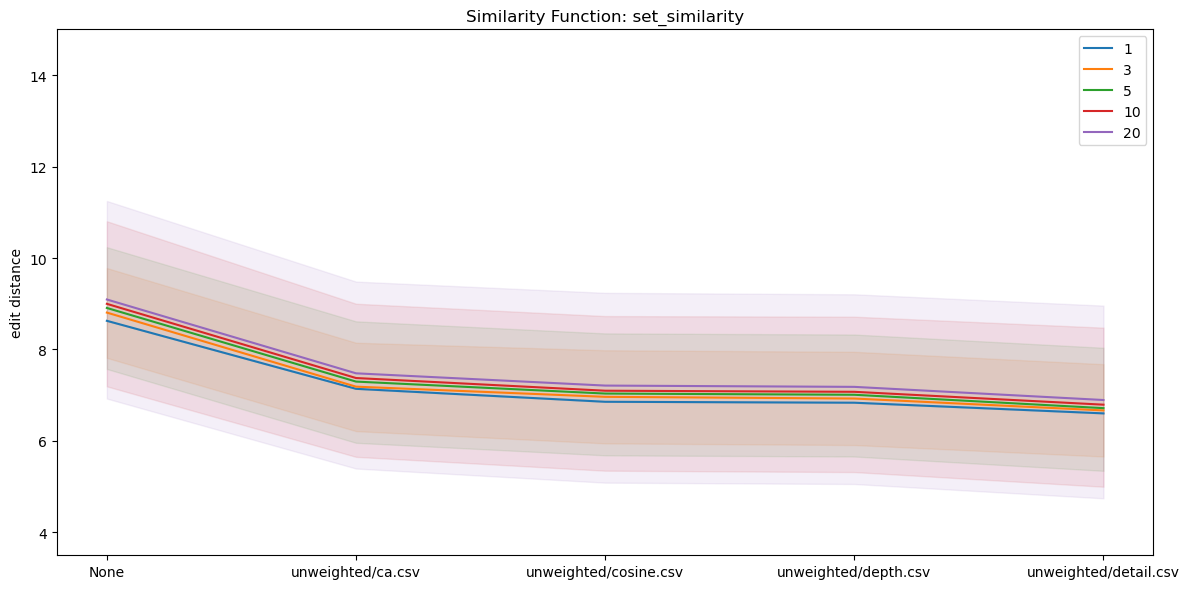

In [72]:
for sim_fun in similarity_functions:
    plotKseries(sim_fun.__name__,distance_tables)

In [73]:
def plotKseries(sim_fun, distance_functions):
    plt.figure(figsize=(7,4), tight_layout=True)
    sim_fun_series = results.loc[results['similarity_function']==sim_fun]
    plt.title("Structural Similarity: " + sim_fun)
    plt.ylim(3.5, 15)
    xlabels = [df.strip(".csv").replace("wsim/","") for df in distance_functions]
    xlabels[1] = 'common attributes'
    xvalues = np.arange(len(distance_functions))
    plt.xticks(xvalues,xlabels)
    plt.ylabel("Levenshtein Similarity")
    colors = list(mcolors.TABLEAU_COLORS.values())
    i = 0
    for k in k_values:
        color = colors[i]
        i+=1
        series = sim_fun_series.loc[sim_fun_series['k']==k]
        plt.plot(xvalues, series['avg'], color=color, label=k, linewidth=2.5)

        upper_limit = series['max']
        lower_limit = series['min']
        #plt.fill_between(xvalues, lower_limit, upper_limit, color=color, alpha=.1)
        plt.plot(xvalues, upper_limit, color=color, alpha=.75, linestyle="dotted", linewidth=2)
        plt.plot(xvalues, lower_limit, color=color, alpha=.75, linestyle="dotted", linewidth=2)        
    plt.legend(loc="best")
    plt.savefig("similarity_analysis_"+sim_fun+".png")
    plt.show()


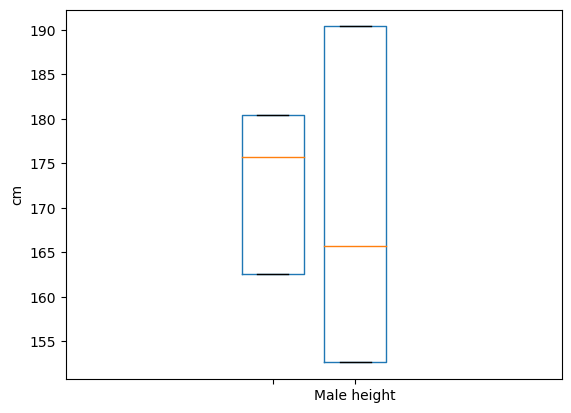

In [74]:
results.head()
fig, ax = plt.subplots()
boxes = [
    {
        'label' : "",
        'whislo': 162.6,    # Bottom whisker position
        'q1'    : 162.6,    # First quartile (25th percentile)
        'med'   : 175.7,    # Median         (50th percentile)
        'q3'    : 180.4,    # Third quartile (75th percentile)
        'whishi': 180.4,    # Top whisker position
        'fliers': []        # Outliers
    },
    {
        'label' : "Male height",
        'whislo': 152.6,    # Bottom whisker position
        'q1'    : 152.6,    # First quartile (25th percentile)
        'med'   : 165.7,    # Median         (50th percentile)
        'q3'    : 190.4,    # Third quartile (75th percentile)
        'whishi': 190.4,    # Top whisker position
        'fliers': []        # Outliers
    }    
]
colors = list(mcolors.TABLEAU_COLORS.values())
boxprops = dict(linewidth=1, color=colors[0])
ax.bxp(boxes, positions= [1,1.20], showfliers=False, boxprops=boxprops)
ax.set_ylabel("cm")
plt.show()
plt.close()

IndexError: index 0 is out of bounds for axis 0 with size 0

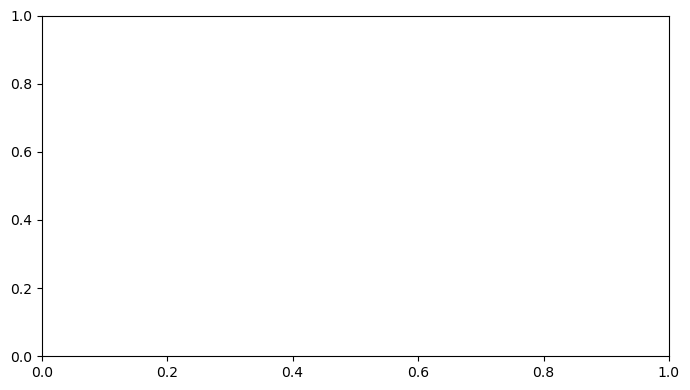

In [75]:

fig, ax = plt.subplots(figsize=(7,4), tight_layout=True)
distance_functions = distance_tables
sim_fun_series = results.loc[results['similarity_function']=='overlap_similarity']
colors = list(mcolors.TABLEAU_COLORS.values())
k=3
series = sim_fun_series.loc[sim_fun_series['k']==k]
boxes = []
for df in distance_functions:
    data_serie = series.loc[series['distance_function']==df]
    data = {
        'label' : "",
        'whislo': data_serie['min'].values[0],    # Bottom whisker position
        'q1'    : data_serie['min'].values[0],    # First quartile (25th percentile)
        'med'   : data_serie['avg'].values[0],    # Median         (50th percentile)
        'q3'    : data_serie['max'].values[0],    # Third quartile (75th percentile)
        'whishi': data_serie['max'].values[0],    # Top whisker position
        'fliers': []  
    }
    boxes.append(data)
boxprops = dict(linewidth=2, color=colors[k])
medianprops = dict(color="black",linewidth=3.5)
bp = ax.bxp(boxes, showfliers=False, boxprops=boxprops, medianprops = medianprops, positions= [i*5 for i in np.arange(0,5)],)
ax.set_ylabel("Levenshtein Similarity")
plt.show()
plt.close()

In [53]:
from matplotlib.lines import Line2D


def plotKserie(ax,k,similarity_function, distance_functions, color, delta_x):
    sim_fun_series = results.loc[results['similarity_function']==similarity_function]
    series = sim_fun_series.loc[sim_fun_series['k']==k]
    label=""
    boxes = []
    for df in distance_functions:
        data_serie = series.loc[series['distance_function']==df]
        data = {
            'label' : label,
            'whislo': data_serie['min'].values[0],    # Bottom whisker position
            'q1'    : data_serie['min'].values[0],    # First quartile (25th percentile)
            'med'   : data_serie['avg'].values[0],    # Median         (50th percentile)
            'q3'    : data_serie['max'].values[0],    # Third quartile (75th percentile)
            'whishi': data_serie['max'].values[0],    # Top whisker position
            'fliers': []  
        }
        boxes.append(data)
    boxprops = dict(linewidth=2, color=color, facecolor=color)
    medianprops = dict(color="orange",linewidth=3.5)
    ax.bxp(boxes, showfliers=False, patch_artist=True, boxprops=boxprops, medianprops=medianprops, positions= [i*7+delta_x for i in np.arange(0,5)],)
    

def plotKseriesBoxPlot(sim_fun, distance_functions):
    fig, ax = plt.subplots(figsize=(7,4), tight_layout=True)
    plt.title("Structural Similarity: " + sim_fun)
    plt.ylim(3.5, 15)
    #xlabels = [df.strip(".csv").replace("wsim/","") for df in distance_functions]
    xlabels = []
    xlabels.append('None')
    xlabels.append('common attributes')
    xlabels.append('cosine')
    xlabels.append('depth')
    xlabels.append('detail')
    print(xlabels)
    xvalues = np.arange(len(distance_functions))
    plt.ylabel("Levenshtein Distance")
    colors = list(mcolors.TABLEAU_COLORS.values())
    i = 0
    custom_lines = []
    for k in k_values:
        color = colors[i]
        i+=1
        plotKserie(ax,k,sim_fun,distance_functions,color,(i+1))
        custom_lines.append(Line2D([0], [0], color=color, lw=3))
    plt.legend(loc="best")
    plt.xticks([4,11,18,25,32])
    ax.set_xticklabels(xlabels)
    ax.legend(custom_lines, k_values, ncol=len(k_values))
    plt.savefig("similarity_analysis_"+sim_fun+".png")    
    plt.show()


['None', 'common attributes', 'cosine', 'depth', 'detail']


IndexError: index 0 is out of bounds for axis 0 with size 0

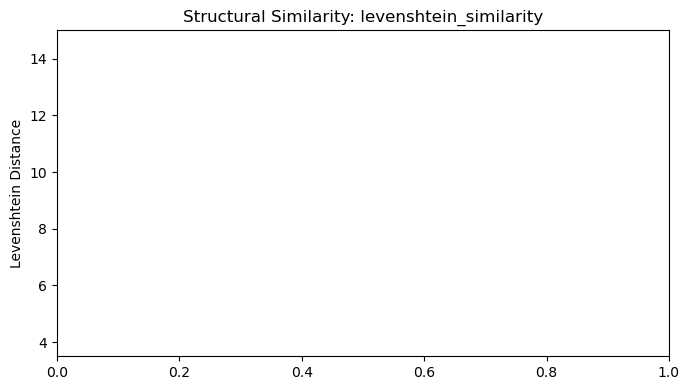

In [54]:
plotKseriesBoxPlot("levenshtein_similarity",distance_tables)

C:\Users\marta\AppData\Local\Temp\ipykernel_19388\2766466639.py:23: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.bxp(boxes, showfliers=False, patch_artist=True, boxprops=boxprops, medianprops=medianprops, positions= [i*7+delta_x for i in np.arange(0,5)],)
C:\Users\marta\AppData\Local\Temp\ipykernel_19388\2766466639.py:23: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.bxp(boxes, showfliers=False, patch_artist=True, boxprops=boxprops, medianprops=medianprops, positions= [i*7+delta_x for i in np.arange(0,5)],)
C:\Users\marta\AppData\Local\Temp\ipykernel_19388\2766466639.py:23: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.bxp(boxes, showfliers=False, patch_artist=True, boxprops=boxprops, medianprops=medianprops, positions= [i*7+delta_x for i in np.arange(0,5)],)
C:\Users\marta\AppData\Local\Temp\ipykernel_19388\2766466639.py:23:

['None', 'common attributes', 'cosine', 'depth', 'detail']


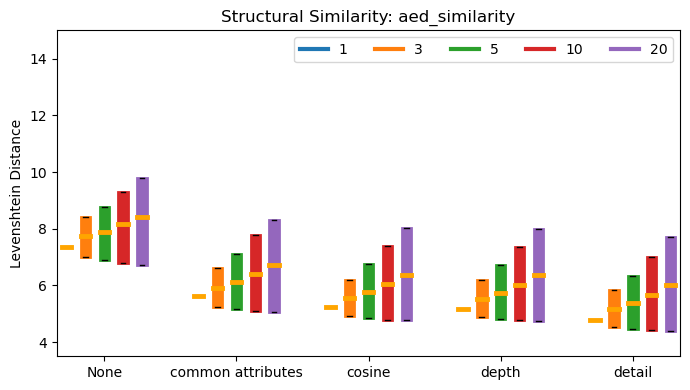

C:\Users\marta\AppData\Local\Temp\ipykernel_19388\2766466639.py:23: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.bxp(boxes, showfliers=False, patch_artist=True, boxprops=boxprops, medianprops=medianprops, positions= [i*7+delta_x for i in np.arange(0,5)],)
C:\Users\marta\AppData\Local\Temp\ipykernel_19388\2766466639.py:23: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.bxp(boxes, showfliers=False, patch_artist=True, boxprops=boxprops, medianprops=medianprops, positions= [i*7+delta_x for i in np.arange(0,5)],)
C:\Users\marta\AppData\Local\Temp\ipykernel_19388\2766466639.py:23: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.bxp(boxes, showfliers=False, patch_artist=True, boxprops=boxprops, medianprops=medianprops, positions= [i*7+delta_x for i in np.arange(0,5)],)
C:\Users\marta\AppData\Local\Temp\ipykernel_19388\2766466639.py:23:

['None', 'common attributes', 'cosine', 'depth', 'detail']


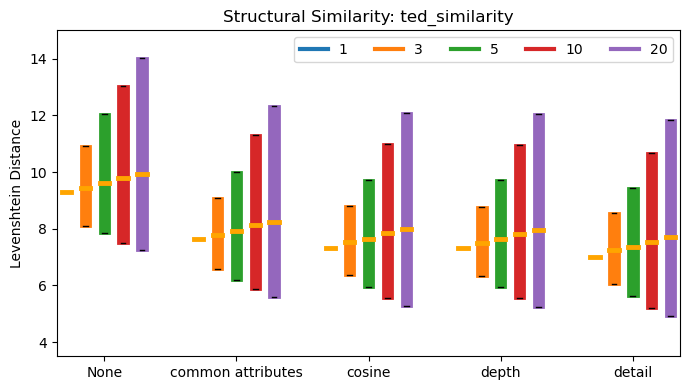

C:\Users\marta\AppData\Local\Temp\ipykernel_19388\2766466639.py:23: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.bxp(boxes, showfliers=False, patch_artist=True, boxprops=boxprops, medianprops=medianprops, positions= [i*7+delta_x for i in np.arange(0,5)],)
C:\Users\marta\AppData\Local\Temp\ipykernel_19388\2766466639.py:23: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.bxp(boxes, showfliers=False, patch_artist=True, boxprops=boxprops, medianprops=medianprops, positions= [i*7+delta_x for i in np.arange(0,5)],)
C:\Users\marta\AppData\Local\Temp\ipykernel_19388\2766466639.py:23: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.bxp(boxes, showfliers=False, patch_artist=True, boxprops=boxprops, medianprops=medianprops, positions= [i*7+delta_x for i in np.arange(0,5)],)
C:\Users\marta\AppData\Local\Temp\ipykernel_19388\2766466639.py:23:

['None', 'common attributes', 'cosine', 'depth', 'detail']


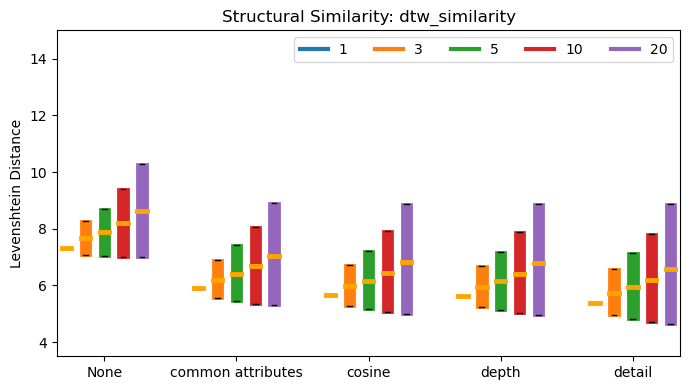

C:\Users\marta\AppData\Local\Temp\ipykernel_19388\2766466639.py:23: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.bxp(boxes, showfliers=False, patch_artist=True, boxprops=boxprops, medianprops=medianprops, positions= [i*7+delta_x for i in np.arange(0,5)],)
C:\Users\marta\AppData\Local\Temp\ipykernel_19388\2766466639.py:23: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.bxp(boxes, showfliers=False, patch_artist=True, boxprops=boxprops, medianprops=medianprops, positions= [i*7+delta_x for i in np.arange(0,5)],)
C:\Users\marta\AppData\Local\Temp\ipykernel_19388\2766466639.py:23: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.bxp(boxes, showfliers=False, patch_artist=True, boxprops=boxprops, medianprops=medianprops, positions= [i*7+delta_x for i in np.arange(0,5)],)
C:\Users\marta\AppData\Local\Temp\ipykernel_19388\2766466639.py:23:

['None', 'common attributes', 'cosine', 'depth', 'detail']


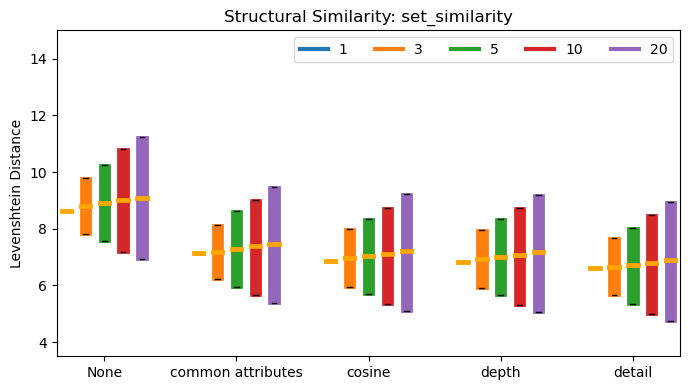

In [113]:
for sim_fun in similarity_functions:
    plotKseriesBoxPlot(sim_fun.__name__,distance_tables)

In [84]:
distance_tables

['None',
 'unweighted/ca.csv',
 'unweighted/cosine.csv',
 'unweighted/depth.csv',
 'unweighted/detail.csv']

In [55]:
def plotSemanticseries(sim_fun, distance_functions):
    plt.figure(figsize=(7,4), tight_layout=True)
    sim_fun_series = results.loc[results['similarity_function']==sim_fun]
    plt.title("Structural Similarity: " + sim_fun)
    plt.ylim(3.5, 12)
    xlabels = [df.strip(".csv").replace("wsim/","") for df in distance_functions]
    xlabels[1] = 'common attributes'
    xvalues = np.arange(len(distance_functions))
    plt.xticks(xvalues,xlabels)
    plt.ylabel("Levenshtein Similarity")
    colors = list(mcolors.TABLEAU_COLORS.values())
    i = 0
    for k in k_values:
        color = colors[i]
        i+=1
        series = sim_fun_series.loc[sim_fun_series['k']==k]
        plt.plot(xvalues, series['avg'], color=color, label=k, linewidth=2.5)

        upper_limit = series['max']
        lower_limit = series['min']
        #plt.fill_between(xvalues, lower_limit, upper_limit, color=color, alpha=.1)
        plt.plot(xvalues, upper_limit, color=color, alpha=.75, linestyle="dotted", linewidth=2)
        plt.plot(xvalues, lower_limit, color=color, alpha=.75, linestyle="dotted", linewidth=2)        
    plt.legend(loc="best")
    plt.savefig("similarity_analysis_"+sim_fun+".png")
    plt.show()

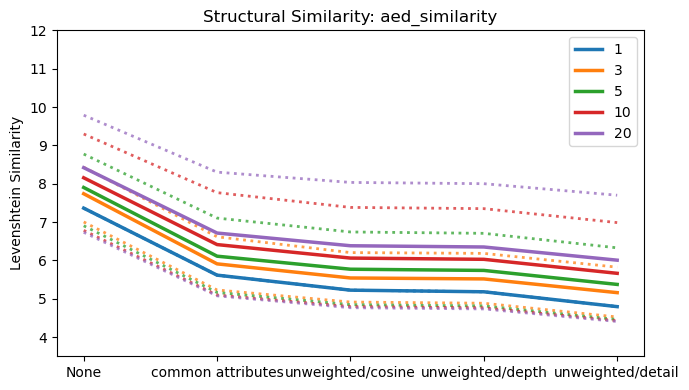

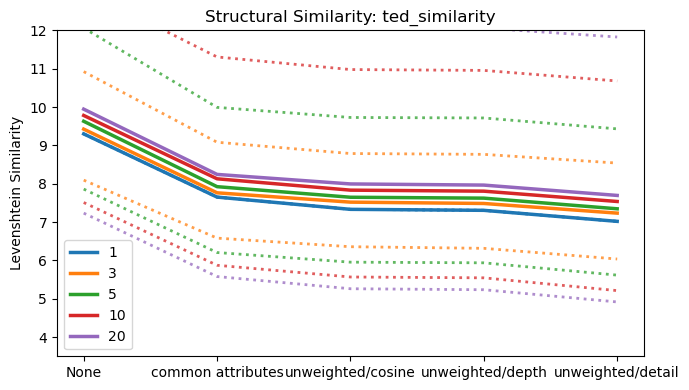

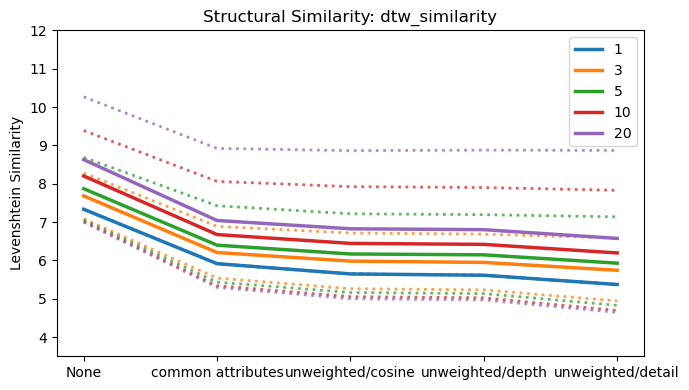

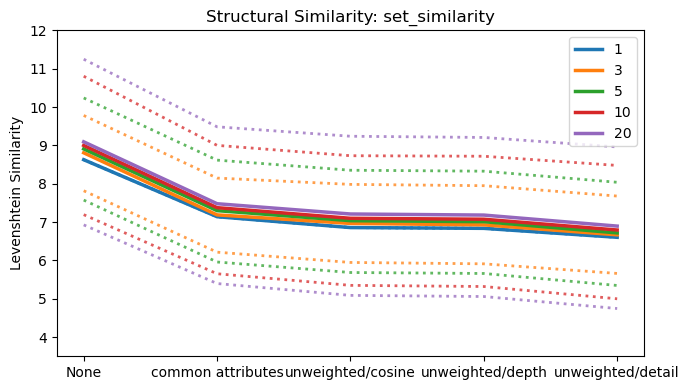

In [56]:
for sim_fun in similarity_functions:
    plotSemanticseries(sim_fun.__name__,distance_tables)

In [57]:
oresults = results.copy()

In [58]:
oresults.sort_values('min')

,Unnamed: 0,k,similarity_function,distance_function,avg,min,max
84,84,20,aed_similarity,unweighted/detail.csv,6.006134,4.406602,7.699699
64,64,10,aed_similarity,unweighted/detail.csv,5.663192,4.427608,6.986121
44,44,5,aed_similarity,unweighted/detail.csv,5.373815,4.459379,6.327876
24,24,3,aed_similarity,unweighted/detail.csv,5.159170,4.524755,5.823647
94,94,20,dtw_similarity,unweighted/detail.csv,6.574193,4.644830,8.869006
...,...,...,...,...,...,...,...
35,35,3,set_similarity,None,8.806667,7.816667,9.780000
45,45,5,ted_similarity,None,9.628667,7.860000,12.060000
25,25,3,ted_similarity,None,9.423333,8.093333,10.923333
15,15,1,set_similarity,None,8.626667,8.626667,8.626667


In [59]:
def getOptimalIndex(casebase,similarity_func,delta=None):
    
    optimal_index =[]
    optimal_distance = []
    
    for q in casebase:
        casebase_cpy=casebase.copy()
        casebase_cpy.remove(q)
        nns=knn(q,casebase_cpy,similarity_func,len(casebase_cpy),delta)
        # distances = [editDistFunc(q["nodes"],q["adj"],nn["nodes"],nn["adj"],delta) for nn in nns]
        distances = [editDistFunc(q,nn,delta) for nn in nns]
        minDistance = min(distances) # get which BT is the most similar
        optimal_distance.append(minDistance)
        optimal_index.append(distances.index(minDistance)) # getting what is the position of the most similar BT
    
    return optimal_index, optimal_distance

In [60]:
leaves_dataframe=pd.read_csv('unweighted/detail.csv',index_col=0)
optimal_index, optimal_distance = getOptimalIndex(casebase, dtw_similarity, delta = semantic_delta)

In [61]:
print(optimal_index, optimal_distance)

[240, 4, 9, 67, 0, 0, 0, 0, 0, 1, 262, 1, 4, 0, 0, 1, 6, 90, 198, 0, 100, 13, 193, 0, 202, 6, 177, 216, 157, 0, 3, 2, 0, 90, 0, 0, 5, 50, 1, 242, 0, 2, 268, 6, 238, 0, 2, 1, 126, 242, 0, 248, 176, 207, 223, 1, 0, 222, 0, 7, 268, 6, 95, 0, 26, 9, 148, 164, 4, 1, 134, 1, 7, 0, 1, 142, 1, 39, 1, 197, 0, 177, 2, 6, 6, 139, 0, 3, 287, 6, 0, 232, 62, 171, 0, 1, 2, 0, 0, 1, 6, 3, 3, 0, 95, 2, 238, 1, 0, 14, 2, 0, 7, 0, 211, 2, 197, 262, 169, 238, 35, 7, 1, 170, 15, 0, 8, 0, 75, 219, 0, 3, 207, 217, 0, 246, 168, 176, 4, 9, 78, 222, 0, 33, 76, 191, 0, 6, 294, 0, 0, 10, 5, 41, 100, 1, 0, 2, 163, 0, 285, 120, 5, 160, 0, 0, 1, 94, 1, 264, 6, 1, 194, 0, 279, 0, 0, 4, 239, 1, 165, 1, 2, 16, 6, 8, 1, 288, 1, 7, 0, 0, 14, 0, 6, 0, 204, 123, 0, 0, 4, 3, 226, 188, 1, 172, 0, 0, 26, 4, 230, 0, 5, 226, 0, 207, 285, 11, 0, 25, 87, 0, 4, 7, 3, 12, 96, 85, 5, 0, 4, 85, 0, 32, 211, 258, 6, 0, 0, 0, 8, 11, 122, 5, 85, 0, 0, 0, 285, 2, 1, 134, 199, 57, 7, 273, 0, 8, 0, 153, 78, 205, 206, 3, 169, 0, 0, 1, 0, 141

In [62]:
similarity_func = dtw_similarity
q = casebase[0]
print_tree(q)
casebase_cpy=casebase.copy()
casebase_cpy.remove(q)
nns=knn(q,casebase_cpy,similarity_func,len(casebase_cpy))
# distances = [editDistFunc(q["nodes"],q["adj"],nn["nodes"],nn["adj"],semantic_delta) for nn in nns]
distances = [editDistFunc(q,nn,semantic_delta) for nn in nns]
print(distances)
minDistance = min(distances)
print(minDistance)
optimal_distance.append(minDistance)
optimal_index.append(distances.index(minDistance))
optimal = nns[distances.index(minDistance)]
print(distances.index(minDistance))
print_tree(optimal)

r(s(/Text/NLPClassifier, /Images/LIME, p(/Tabular/Importance, s(/Images/Anchors, /Tabular/LIME, s(s(/Tabular/DisCERN, /Text/LIME), /Images/GradCamTorch), /Images/Counterfactuals), /Images/LIME, /Images/Anchors)))
[11.0, 9.264322916666668, 8.970138888888888, 9.255063657407408, 8.64982638888889, 9.67490552779701, 9.519386574074074, 9.919212962962963, 10.542100694444445, 10.957118055555556, 10.213541666666668, 11.934540944463677, 10.426319444444445, 10.335069444444445, 10.713483796296295, 9.707118055555556, 8.883292824074074, 8.847164351851852, 9.053761574074073, 7.542100694444445, 11.262152777777779, 10.618969907407408, 10.73822337962963, 9.941840277777779, 8.969357638888889, 10.394184027777778, 9.70167824074074, 9.524305555555555, 9.536400462962963, 10.11111111111111, 9.75954861111111, 11.569349972241454, 10.631886574074073, 10.098900462962963, 12.369733796296297, 10.388483796296295, 10.566493055555556, 10.359363425925928, 9.87109375, 11.891684027777778, 9.519523583352566, 8.88935185185

In [ ]:
ted.ted(q["nodes"],q["adj"],optimal["nodes"],optimal["adj"],semantic_delta)

In [ ]:

# x_nodes = ['a', 'b', 'a', 'a', 'a']
# x_adj   = [[1, 4], [2, 3], [], [], []]
# y_nodes = ['l', 'm', 'n']
# y_adj   = [[1], [2], []]

# internal,leaves = loadNodes()
# x = random_generator(internal,leaves,1, 2, 2, 3)
# y = random_generator(internal,leaves,1, 2, 2, 3)

# def d(x,y):
#     if x==y:
#         return 0
#     elif (x==None or y==None):
#         return .51
#     else:
#         return 1
    
    
# x_nodes = ['r', 's1', 'p'] 
# x_adj = [[1], [2], []] 
# y_nodes = ['r', 's', 'p', 's', '/Timeseries/CBRFox'] 
# y_adj = [[1], [2], [3], [4], []] 

# x_nodes = x["nodes"]
# y_nodes = y["nodes"]
# x_adj = x["adj"]
# y_adj = y["adj"]

# print(x_nodes)
# print(x_adj)
# print(y_nodes)
# print(y_adj)

# print('The tree edit distance is  between  \n%s \n%s \nis: %f.' % (tree_utils.tree_to_string(x_nodes, x_adj), tree_utils.tree_to_string(y_nodes, y_adj), ted.ted(x_nodes, x_adj, y_nodes, y_adj,d_fun)))
# #print('By contrast, the sequence edit distance on the node lists would be %d.' % (sed.standard_sed(x_nodes, y_nodes)))

# print('The following nodes have been aligned.')
# alignment = ted.ted_backtrace(x_nodes, x_adj, y_nodes, y_adj,d_fun)
# print(alignment.render(x_nodes, y_nodes))

# script = tree_edits.alignment_to_script(alignment, x_nodes, x_adj, y_nodes, y_adj)
# x_nodes2, x_adj2 = script.apply(x_nodes, x_adj)
# print('The following edits transform \n%s to \n%s: \n%s' % (tree_utils.tree_to_string(x_nodes, x_adj), tree_utils.tree_to_string(x_nodes2, x_adj2), str(script))) 

In [63]:
def plotOptimalIndexesHistogram(_indexes,sim_func_name,dist_func_name):
    plt.figure(figsize=(8,4), tight_layout=True)

    plt.title("Similarity: " + sim_func_name+ "   Semantic: " + dist_func_name)
    plt.hist(_indexes)
    plt.legend(loc='upper right', title_fontsize = 13, labels=['optimal index'])
    plt.xticks(np.arange(0,len(casebase),20)) # 5
    #plt.ylim(0, 15)
    plt.ylim(-5, 50)

    plt.savefig("optimal_"+sim_func_name+"_"+dist_func_name.replace("/", "_" )+".png")
    plt.show()
    print("Mean: " + str(np.mean(_indexes))+"   STD: " + str(np.std(_indexes)))



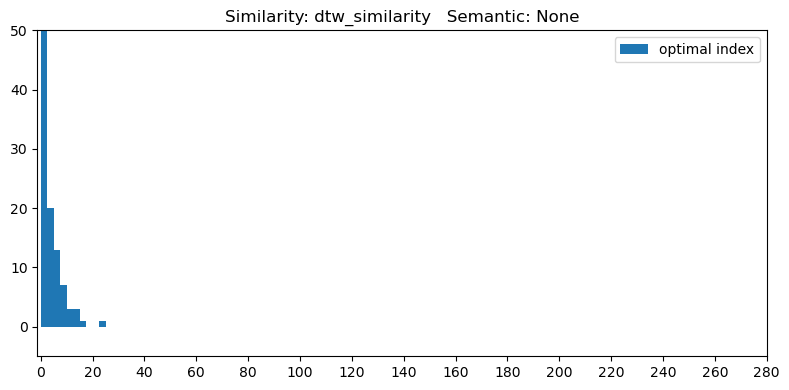

Mean: 1.2766666666666666   STD: 2.8913875946026715


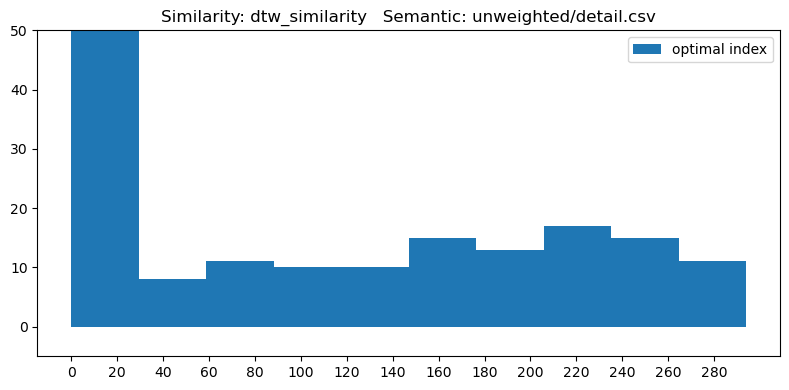

Mean: 65.33666666666667   STD: 92.96972619562182


In [64]:
leaves_dataframe=pd.read_csv('unweighted/detail.csv',index_col=0)
optimal_index, optimal_distance = getOptimalIndex(casebase, dtw_similarity, delta = None)
plotOptimalIndexesHistogram(optimal_index,'dtw_similarity','None')
optimal_index, optimal_distance = getOptimalIndex(casebase, dtw_similarity, delta = semantic_delta)
plotOptimalIndexesHistogram(optimal_index,'dtw_similarity','unweighted/detail.csv')

In [65]:
def plotOptimalIndexesHistogram(_indexes,sim_func_name,dist_func_name):
    plt.figure(figsize=(7,4), tight_layout=True)

    plt.title("Structural Similarity: " + sim_func_name+ "   Semantic metric: " + dist_func_name + "\nMean: " + str(np.mean(_indexes)// 0.01 / 100)+"   STD: " + str(np.std(_indexes)// 0.01 / 100))
    plt.hist(_indexes)
    plt.legend(loc='upper right', title_fontsize = 13, labels=['optimal index'])
    plt.xticks(np.arange(0,len(casebase),20)) #5
    plt.ylim(0, 20)

    plt.savefig("optimal_"+sim_func_name+"_"+dist_func_name.replace("/", "_" )+".png")
    plt.show()
    print("Mean: " + str(np.mean(_indexes))+"   STD: " + str(np.std(_indexes)))



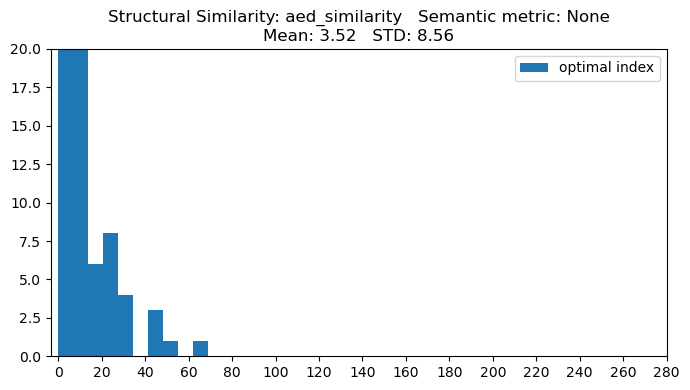

Mean: 3.53   STD: 8.568689125725902


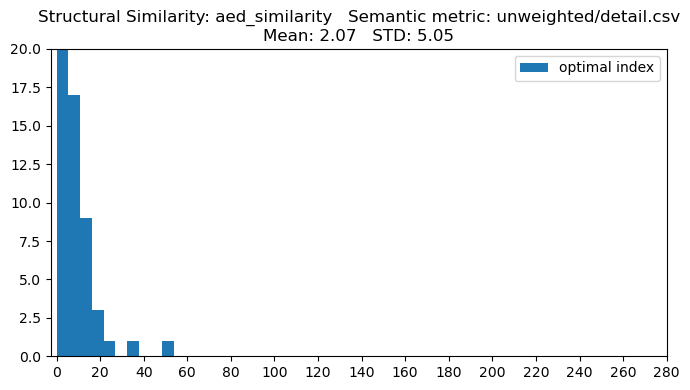

Mean: 2.0766666666666667   STD: 5.05543821597649


In [66]:
# insertion_cost = 3.
# deletion_cost = 3.
# leave_change = 1.
# default_cost = 1
# distance_factor = 1
leaves_dataframe=pd.read_csv('unweighted/detail.csv',index_col=0)
optimal_index, optimal_distance = getOptimalIndex(casebase, aed_similarity, delta = std_delta)
plotOptimalIndexesHistogram(optimal_index,'aed_similarity','None')
optimal_index, optimal_distance = getOptimalIndex(casebase, aed_similarity, delta = semantic_delta)
plotOptimalIndexesHistogram(optimal_index,'aed_similarity','unweighted/detail.csv')

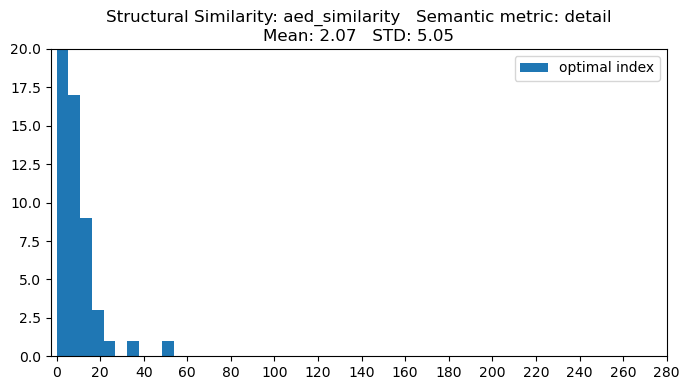

Mean: 2.0766666666666667   STD: 5.05543821597649


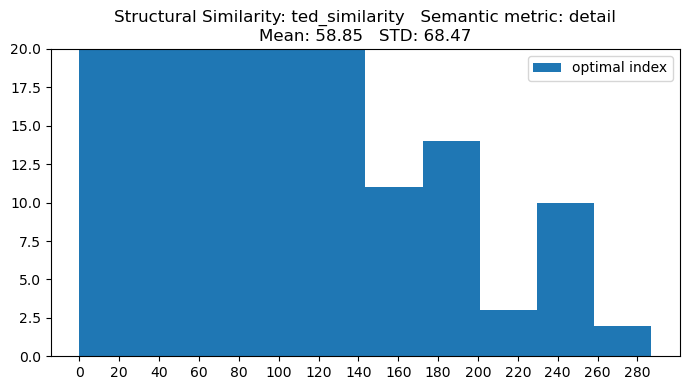

Mean: 58.86   STD: 68.47350144398926


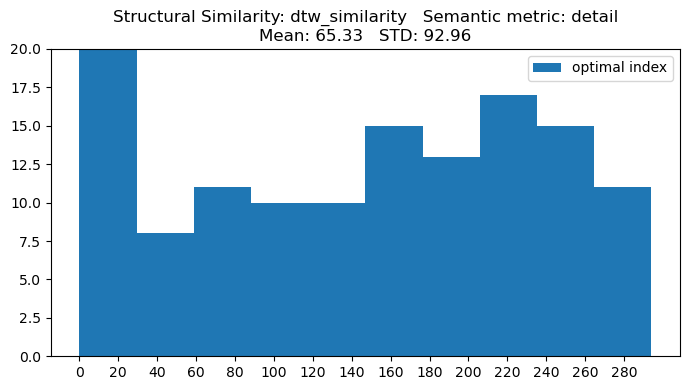

Mean: 65.33666666666667   STD: 92.96972619562182


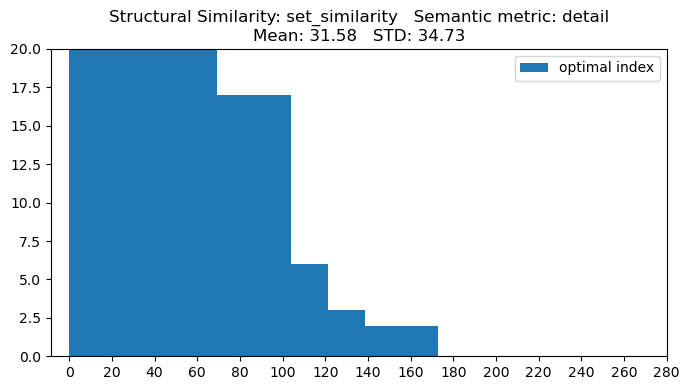

Mean: 31.59   STD: 34.73444831863607


In [67]:
leaves_dataframe=pd.read_csv('unweighted/detail.csv',index_col=0)
for sim_fun in similarity_functions:
    optimal_index, optimal_distance = getOptimalIndex(casebase, sim_fun,semantic_delta)
    plotOptimalIndexesHistogram(optimal_index,sim_fun.__name__,'detail')

In [74]:
def plotOptimalIndexesHistogram(_indexes,sim_func_name,dist_func_name):
    plt.figure(figsize=(7,4), tight_layout=True)

    plt.title("Structural Similarity: " + sim_func_name+ "   Semantic metric: " + dist_func_name + "\nMean: " + str(np.mean(_indexes)// 0.01 / 100)+"   STD: " + str(np.std(_indexes)// 0.01 / 100))
    plt.hist(_indexes)
    plt.legend(loc='upper right', title_fontsize = 13, labels=['optimal index'])
    plt.xticks(np.arange(0,len(casebase),20)) #5
    plt.ylim(0, 300)

    plt.savefig("optimal_"+sim_func_name+"_"+dist_func_name.replace("/", "_" )+".png")
    plt.show()
    print("Mean: " + str(np.mean(_indexes))+"   STD: " + str(np.std(_indexes)))


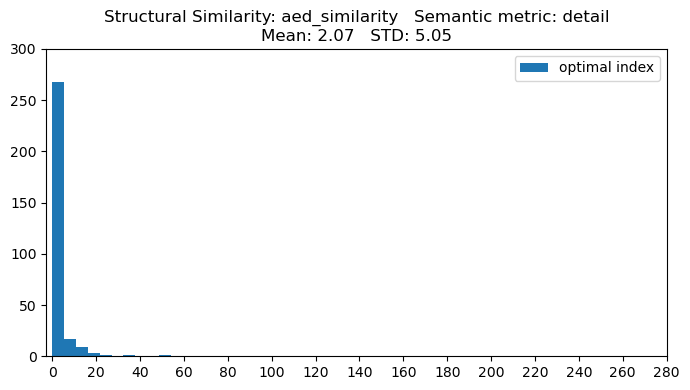

Mean: 2.0766666666666667   STD: 5.05543821597649


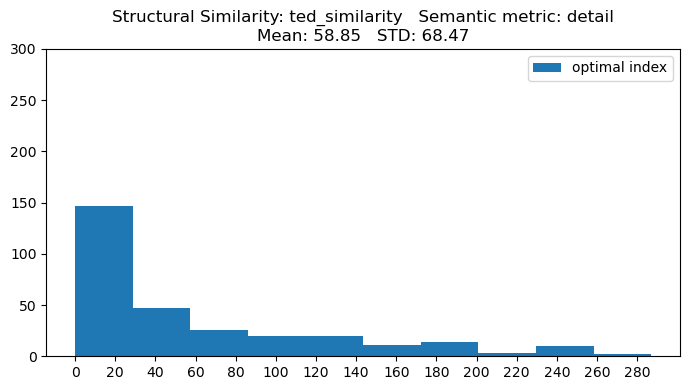

Mean: 58.86   STD: 68.47350144398926


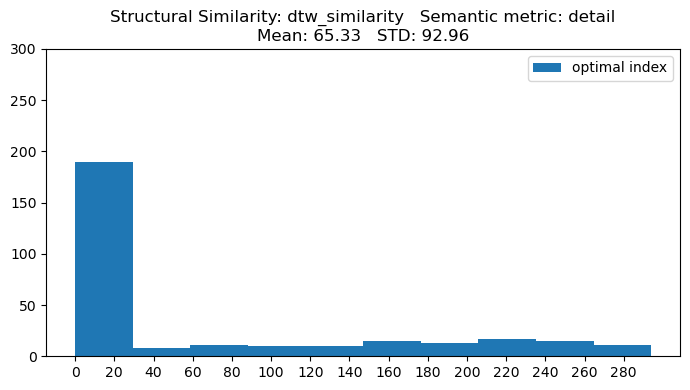

Mean: 65.33666666666667   STD: 92.96972619562182


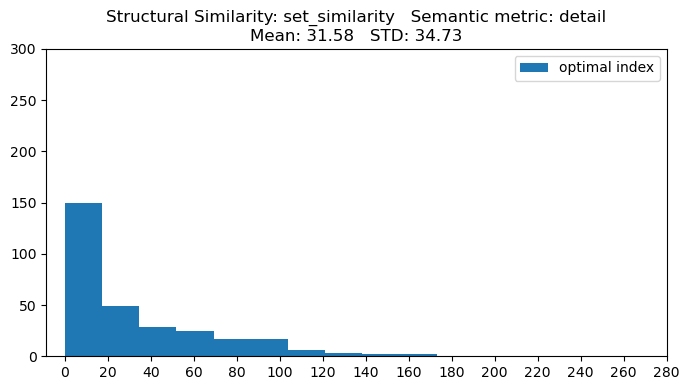

Mean: 31.59   STD: 34.73444831863607


In [75]:
leaves_dataframe=pd.read_csv('unweighted/detail.csv',index_col=0)
for sim_fun in similarity_functions:
    optimal_index, optimal_distance = getOptimalIndex(casebase, sim_fun,semantic_delta)
    plotOptimalIndexesHistogram(optimal_index,sim_fun.__name__,'detail')

In [ ]:
# No delta
#leaves_dataframe=pd.read_csv('wsim/detail.csv',index_col=0)
#for sim_fun in similarity_functions:
#    optimal_index, optimal_distance = getOptimalIndex(casebase, sim_fun)
#    plotOptimalIndexesHistogram(optimal_index,sim_fun.__name__,'None')

In [ ]:
leaves_dataframe=pd.read_csv('unweighted/detail.csv',index_col=0)
for sim_fun in similarity_functions:
    optimal_index, optimal_distance = getOptimalIndex(casebase, sim_fun,semantic_delta)
    plotOptimalIndexesHistogram(optimal_index,sim_fun.__name__,'unweighted/detail')

In [ ]:
leaves_dataframe=pd.read_csv('unweighted/detail.csv',index_col=0)
for sim_fun in similarity_functions:
    optimal_index, optimal_distance = getOptimalIndex(casebase, sim_fun,std_delta)
    plotOptimalIndexesHistogram(optimal_index,sim_fun.__name__,'None')